In [1]:
import sys
import os

parent_path = ".."
sys.path.append(os.path.abspath(parent_path))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from health_causenet import constants
import json
import pathlib
from tqdm.autonotebook import tqdm
import operator
from nltk import agreement
import nltk
import sklearn.metrics

tqdm.pandas()

plt.rcParams["font.family"] = "serif"

/tmp/ipykernel_300249/3829021575.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
def p_mean_threshold_combiner(cause, effect, p):
    if p == 0:
        return np.sqrt(cause * effect)
    if p == float("inf"):
        return np.maximum(cause, effect)
    if p == -float("inf"):
        return np.minimum(cause, effect)
    return ((cause ** p + effect ** p) / 2) ** (1 / p)

In [3]:
test_causenet = pd.read_pickle(os.path.join(constants.BASE_PATH, "test_causenet.pkl"))
test_causenet_predictions = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_predictions.pkl")
)
test_causenet = test_causenet.merge(
    test_causenet_predictions, on=["cause", "effect", "dataset"], how="left"
)

sentence_test_causenet = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "sentence_test_causenet.pkl")
)
sentence_test_causenet_predictions = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "sentence_test_causenet_predictions.pkl")
)
sentence_test_causenet = sentence_test_causenet.merge(
    sentence_test_causenet_predictions,
    on=["cause", "effect", "dataset", "sentence"],
    how="left",
)

assert (
    not test_causenet.loc[:, test_causenet.columns.str.startswith("medical_score")]
    .isna()
    .any()
    .any()
)
assert (
    not sentence_test_causenet.loc[
        :, sentence_test_causenet.columns.str.startswith("medical_score")
    ]
    .isna()
    .any()
    .any()
)

test_causenet = test_causenet.loc[test_causenet.dataset.isin(["random_full", "random_support"])]
sentence_test_causenet = sentence_test_causenet.loc[sentence_test_causenet.dataset == "random_full"]
sentence_test_causenet["dataset"] = "sentence"
test_causenet = pd.concat([test_causenet, sentence_test_causenet]).reset_index(drop=True)
test_causenet

,cause,effect,support,count,dataset,cause_origin,effect_origin,evaluation,"medical_score-cause-term_domain_specificity-pubmed-(1, 1)-1","medical_score-effect-term_domain_specificity-pubmed-(1, 1)-1",...,"medical_score-effect-discriminative_weight-pubmed-(1, 3)-neg_1","medical_score-effect-discriminative_weight-textbook-(1, 3)-neg_1","medical_score-effect-discriminative_weight-pubmed_central-(1, 3)-neg_1","medical_score-effect-discriminative_weight-encyclopedia-(1, 3)-neg_1","medical_score-effect-discriminative_weight-pubmed-(1, 3)-0","medical_score-effect-discriminative_weight-textbook-(1, 3)-0","medical_score-effect-discriminative_weight-pubmed_central-(1, 3)-0","medical_score-effect-discriminative_weight-encyclopedia-(1, 3)-0",sentence,manual_evaluation
0,material,death,3.0,4.0,random_support,NaN,NaN,0,0.868993,0.580596,...,65.054640,21.417447,57.204029,18.803064,65.054640,21.417447,57.204029,18.803064,NaN,NaN
1,lack of foresight,mesothelioma diagnosis,2.0,2.0,random_support,NaN,NaN,1,0.739327,3.534990,...,356.915862,10.842975,320.990466,171.703867,367.002471,33.842025,328.022429,178.860266,NaN,NaN
2,asbestos,damage to the lungs,2.0,2.0,random_support,NaN,NaN,1,1.342630,1.236596,...,81.225197,16.476861,86.053039,27.965749,107.961097,22.650537,107.075274,75.998875,NaN,NaN
3,lactic acidosis,metabolic acidosis,2.0,4.0,random_support,NaN,NaN,1,3.205030,3.650117,...,435.895634,49.679707,376.593515,238.035163,436.969875,58.095478,379.705844,247.855855,NaN,NaN
4,embolism,condition,2.0,3.0,random_support,NaN,NaN,1,3.311735,1.437818,...,174.290807,64.784479,204.719556,179.319512,174.290807,64.784479,204.719556,179.319512,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,termination of the company 's pexelizumab prog...,non-recurrence of costs,1.0,3.0,sentence,NaN,NaN,0,0.765124,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,The decrease in R&D expenses in 2007 reflected...,0.0
2996,medical neglect of a patient at another nursin...,abuse,1.0,2.0,sentence,NaN,NaN,0,0.783367,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,That dispute arose when HRS found indications ...,0.0
2997,disorder,shoulder contractions,1.0,8.0,sentence,NaN,NaN,1,1.281044,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,This is a disorder that causes severe neck and...,1.0
2998,car accidents,rib fracture in a child,1.0,1.0,sentence,NaN,NaN,1,0.831662,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A rib fracture in a child is mainly caused by ...,1.0


In [8]:
test_causenet.groupby("dataset").evaluation.agg(["sum", "mean", "size"])

,sum,mean,size
dataset,,,
random_full,214,0.214,1000
random_support,503,0.503,1000
sentence,214,0.214,1000


In [9]:
num_words = (
    test_causenet.apply(
        lambda x: pd.Series(x[["cause", "effect"]].values.ravel()).map(
            lambda y: len(nltk.tokenize.word_tokenize(y))
        ),
        axis=1,
    )
    .sum(axis=1)
    .groupby(test_causenet.dataset)
    .mean()
    / 2
)
print("phrases")
for dataset, word_count in num_words.round(2).to_dict().items():
    print(dataset, word_count)
print("-------------------")
print("sentences")
num_words = (
    sentence_test_causenet.apply(
        lambda x: pd.Series(x[["sentence"]].values.ravel()).map(
            lambda y: len(nltk.tokenize.word_tokenize(y))
        ),
        axis=1,
    )
    .sum(axis=1)
    .groupby(sentence_test_causenet.dataset)
    .mean()
)
for dataset, word_count in num_words.round(2).to_dict().items():
    print(dataset, word_count)

phrases
random_full 3.6
random_support 1.7
sentence 3.6
-------------------
sentences
sentence 30.31


In [6]:
with open(constants.MANUAL_EVALUATION_PATH, "r") as file:
    manual_eval_dict = json.load(file)
data = []
for key, value in manual_eval_dict.items():
    cause, effect = key.split("->")
    data.append({"cause": cause, "effect": effect, "evaluation": value})
evals = pd.DataFrame(data).rename({"evaluation": "rater"}, axis=1)
evals = evals.set_index(["cause", "effect"])
evals = evals.add_suffix("-0")

iterator = enumerate(pathlib.Path(constants.BASE_PATH).glob("agreement_relations*.csv"))

for idx, path in iterator:
    other_eval = pd.read_csv(path, index_col=0).set_index(["cause", "effect"])
    other_eval = other_eval.rename({"health-related": "rater"}, axis=1)
    other_eval = other_eval.add_suffix(f"-{idx + 1}")
    evals = evals.join(other_eval, how="inner")

rating_data = evals.reset_index(drop=True).stack().swaplevel().reset_index().values
rating_data = list(tuple(row) for row in rating_data)

rating_task = agreement.AnnotationTask(data=rating_data)
print("kappa " + str(rating_task.kappa()))
print("fleiss " + str(rating_task.multi_kappa()))
print("alpha " + str(rating_task.alpha()))
print("scotts " + str(rating_task.pi()))

kappa 0.7578139040430347
fleiss 0.7546012269938649
alpha 0.7541118421052632
scotts 0.7532894736842104


In [7]:
evals = (
    test_causenet.loc[test_causenet.dataset == "practitioner_full"]
    .set_index(["cause", "effect"])
    .evaluation
)
evals.name = "rater-0"
evals = evals.to_frame()
other_eval = pd.read_csv(
    pathlib.Path(constants.BASE_PATH).joinpath("practitioner_other.csv"), index_col=0
)
other_eval = other_eval.set_index(["cause", "effect"])
other_eval = other_eval.loc[~other_eval.label.isna()]
other_eval.label = other_eval.label.astype(int)
other_eval = other_eval.rename({"label": "rater-1"}, axis=1)
evals = evals.join(other_eval, how="inner")

rating_data = evals.reset_index(drop=True).stack().swaplevel().reset_index().values
rating_data = list(tuple(row) for row in rating_data)

rating_task = agreement.AnnotationTask(data=rating_data)
print("kappa " + str(rating_task.kappa()))
print("fleiss " + str(rating_task.multi_kappa()))
print("alpha " + str(rating_task.alpha()))
print("scotts " + str(rating_task.pi()))

kappa 0.14326511185149934
fleiss 0.14326511185149934
alpha 0.14714285714285713
scotts 0.14285714285714296


In [8]:
evals.loc[evals["rater-0"] != evals["rater-1"]]

,,rater-0,rater-1
cause,effect,,
respiratory illness,carbon dioxide on levels of pollutants,0,1
critical events,disorder,1,0
viral replication in the cns,ability to detect features of the csf viral population,1,0
fava beans,severe hypertensive reactions,0,1
single processing nodes,problems,1,0
problems,poor treatment,1,0
poor treatment,problems,1,0
physical activity,damage,1,0
exposure to sun,recurrences of hsv-1,0,1


In [9]:
evals = sentence_test_causenet.set_index(["cause", "effect"]).dropna(
    subset=["manual_evaluation"]
)
evals = evals.loc[:, ["evaluation", "manual_evaluation"]].astype(int)
rating_data = evals.reset_index(drop=True).stack().swaplevel().reset_index().values
rating_data = list(tuple(row) for row in rating_data)

rating_task = agreement.AnnotationTask(data=rating_data)
print("kappa " + str(rating_task.kappa()))
print("fleiss " + str(rating_task.multi_kappa()))
print("alpha " + str(rating_task.alpha()))
print("scotts " + str(rating_task.pi()))

kappa 0.9649254080344198
fleiss 0.9649254080344198
alpha 0.964937821198674
scotts 0.9649202813393436


In [10]:
print((evals.loc[evals["evaluation"] != evals["manual_evaluation"]]).sum())
evals.loc[evals["evaluation"] != evals["manual_evaluation"]]

evaluation            1
manual_evaluation    11
dtype: int64


,,evaluation,manual_evaluation
cause,effect,,
opportunistic condition,life forms in the blood,0,1
hl,discomfort to the infant,0,1
faulty engineering of toyota,deaths,0,1
cuts already inflicted,pain,1,0
sound,particular feeling,0,1
fresh produce,public health from pathogens,0,1
haplotypes,susceptibility,0,1
limitation,efficiency,0,1
images they will encounter,involuntary physical/psychological reaction,0,1


In [25]:
def parse_test_causenet_combined(test_causenet, ops):
    test_causenet_combined = []

    total = len(ops)

    for op_name, op in tqdm(ops.items()):
        column_names = sorted(test_causenet.filter(regex="medical_score"))
        filtered = test_causenet[column_names]
        half = filtered.shape[1] // 2
        combined = op(filtered.iloc[:, :half].values, filtered.iloc[:, half:].values,)
        test_causenet_combined.append(
            pd.DataFrame(
                combined,
                columns=list(
                    name[20:] + "-" + op_name for name in filtered.iloc[:, :half]
                ),
            )
        )
    test_causenet_combined = pd.concat(test_causenet_combined, axis=1)
    return test_causenet_combined


# or and p=inf_mean are the same
ops = {
    "p=neg_inf_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, -float("inf")),
    "p=neg_10_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, -10),
    "p=neg_5_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, -5),
    "p=neg_2_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, -2),
    "p=neg_1_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, -1),
    "p=0_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, 0),
    "p=1_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, 1),
    "p=2_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, 2),
    "p=5_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, 5),
    "p=10_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, 10),
    "p=inf_mean": lambda cause, effect: p_mean_threshold_combiner(cause, effect, float("inf")),
}
test_causenet_combined = parse_test_causenet_combined(test_causenet, ops)

  0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_3378491/115610357.py:8: RuntimeWarning: divide by zero encountered in power
  return ((cause ** p + effect ** p) / 2) ** (1 / p)
/tmp/ipykernel_3378491/115610357.py:8: RuntimeWarning: divide by zero encountered in power
  return ((cause ** p + effect ** p) / 2) ** (1 / p)
/tmp/ipykernel_3378491/115610357.py:8: RuntimeWarning: divide by zero encountered in power
  return ((cause ** p + effect ** p) / 2) ** (1 / p)
/tmp/ipykernel_3378491/115610357.py:8: RuntimeWarning: divide by zero encountered in reciprocal
  return ((cause ** p + effect ** p) / 2) ** (1 / p)


In [26]:
test_causenet_combined.to_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_combined.pkl")
)

In [4]:
test_causenet_combined = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_combined.pkl")
)
test_causenet_combined

,"contrastive_weight-encyclopedia-(1, 1)-0-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-1-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-10-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-2-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-5-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-inf-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_1-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_10-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_2-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_5-p=neg_inf_mean",...,"term_domain_specificity-textbook-(1, 3)-1-p=inf_mean","term_domain_specificity-textbook-(1, 3)-10-p=inf_mean","term_domain_specificity-textbook-(1, 3)-2-p=inf_mean","term_domain_specificity-textbook-(1, 3)-5-p=inf_mean","term_domain_specificity-textbook-(1, 3)-inf-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_1-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_10-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_2-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_5-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_inf-p=inf_mean"
0,65.933325,65.933325,65.933325,65.933325,65.933325,65.933325,65.933325,65.933325,65.933325,65.933325,...,0.668799,0.668799,0.668799,0.668799,0.668799,0.668799,0.668799,0.668799,0.668799,0.668799
1,56.111194,38.700827,65.379759,48.931429,59.373694,72.933463,54.235982,46.243061,52.537026,48.897504,...,2.227317,3.755851,2.743111,3.392185,4.191259,0.681375,0.332689,0.472301,0.379012,0.280792
2,62.146614,62.146614,62.146614,62.146614,62.146614,62.146614,57.645719,41.854913,53.506999,46.222332,...,0.537442,0.975680,0.667126,0.874176,1.110644,0.448074,0.448074,0.448074,0.448074,0.448074
3,81.115528,81.745700,86.408299,82.371051,84.132450,91.876372,80.490215,76.146956,79.879143,78.206791,...,1.148534,1.361173,1.180650,1.268464,1.513839,1.087559,0.945712,1.060885,1.000154,0.855794
4,80.481637,80.481637,80.481637,80.481637,80.481637,80.481637,80.481637,80.481637,80.481637,80.481637,...,1.014004,1.014004,1.014004,1.014004,1.014004,1.014004,1.014004,1.014004,1.014004,1.014004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.404084,3.258437,0.965237,2.274515,5.057795,0.409407,0.213249,0.345938,0.269523,0.146197
2996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.743492,2.976322,1.296982,2.292776,4.191259,0.331804,0.044245,0.171360,0.065425,0.029749
2997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.731866,2.844768,1.186969,2.134502,4.150999,0.342500,0.105215,0.238152,0.140124,0.073085
2998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.560239,2.946324,1.027860,2.174583,4.150999,0.254529,0.042841,0.141116,0.059895,0.030593


In [28]:
def parse_test_causenet_medical(test_causenet_combined, method_threshold_dict):
    test_causenet_medical = []

    total = 0
    for thresholds in method_threshold_dict.values():
        total += len(thresholds)

    pg = tqdm(total=total)
    for method_name, thresholds in method_threshold_dict.items():
        for threshold in thresholds:
            column_names = sorted(test_causenet_combined.filter(regex=method_name))
            filtered = test_causenet_combined[column_names]
            medical = filtered >= threshold
            medical = medical.add_suffix(f"-{threshold}-medical")
            test_causenet_medical.append(medical)
            pg.update()
    test_causenet_medical = pd.concat(test_causenet_medical, axis=1)
    return test_causenet_medical


taggers = ["quickumls", "scispacy", "metamap", "ctakes"]
method_threshold_dict = {
    "|".join(taggers): [round(thresh, 4) for thresh in np.linspace(0, 1, 100)],
    "term_domain_specificity": [round(thresh, 4) for thresh in np.linspace(0, 6, 100)],
    "contrastive_weight": [round(thresh, 4) for thresh in np.linspace(50, 140, 100)],
    "discriminative_weight": [round(thresh, 4) for thresh in np.linspace(0, 1100, 100)],
    "health_bert": [round(thresh, 4) for thresh in np.linspace(0, 1, 100)],
}

test_causenet_medical = parse_test_causenet_medical(
    test_causenet_combined, method_threshold_dict
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
test_causenet_medical.to_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_medical.pkl")
)

In [5]:
test_causenet_medical = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_medical.pkl")
)
test_causenet_medical

,ctakes-full-p=0-0.0-medical,ctakes-full-p=10_mean-0.0-medical,ctakes-full-p=1_mean-0.0-medical,ctakes-full-p=2_mean-0.0-medical,ctakes-full-p=5_mean-0.0-medical,ctakes-full-p=inf_mean-0.0-medical,ctakes-full-p=neg_10_mean-0.0-medical,ctakes-full-p=neg_1_mean-0.0-medical,ctakes-full-p=neg_2_mean-0.0-medical,ctakes-full-p=neg_5_mean-0.0-medical,...,health_bert-scibert-pubmed-sentence-p=10_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=1_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=2_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=5_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=inf_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=neg_10_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=neg_1_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=neg_2_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=neg_5_mean-1.0-medical,health_bert-scibert-pubmed-sentence-p=neg_inf_mean-1.0-medical
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2996,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2997,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2998,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [6]:
seed = 42
sample_idcs = test_causenet_medical.groupby(test_causenet.dataset).sample(800, random_state=seed).index

validation_causenet_medical = test_causenet_medical.loc[sample_idcs]
test_causenet_medical = test_causenet_medical.loc[~test_causenet_medical.index.isin(sample_idcs.values)]

validation_causenet = test_causenet.loc[sample_idcs]
test_causenet = test_causenet.loc[~test_causenet.index.isin(sample_idcs.values)]

validation_causenet_combined = test_causenet_combined.loc[sample_idcs]
test_causenet_combined = test_causenet_combined.loc[~test_causenet_combined.index.isin(sample_idcs.values)]

validation_causenet.shape, test_causenet.shape

((2400, 938), (600, 938))

In [10]:
def evaluate_test_causenet_medical(test_causenet, test_causenet_medical):
    _tp = []
    _fp = []
    _tn = []
    _fn = []
    test_causenet_medical = test_causenet_medical.loc[~test_causenet.evaluation.isna()]
    test_causenet = test_causenet.loc[~test_causenet.evaluation.isna()]
    test_causenet.evaluation = test_causenet.evaluation.astype(int)
    for _dataset in tqdm(test_causenet.dataset.drop_duplicates().values):
        dataset_bool = test_causenet.dataset == _dataset
        _test_causenet_medical = test_causenet_medical.loc[dataset_bool]
        _test_causenet = test_causenet.loc[dataset_bool]
        _tp.append(
            (_test_causenet_medical & _test_causenet.evaluation.values[:, np.newaxis])
            .sum()
            .rename(_dataset)
        )
        _fp.append(
            (_test_causenet_medical & ~_test_causenet.evaluation.values[:, np.newaxis])
            .sum()
            .rename(_dataset)
        )
        _tn.append(
            (~_test_causenet_medical & ~_test_causenet.evaluation.values[:, np.newaxis])
            .loc[dataset_bool]
            .sum()
            .rename(_dataset)
        )
        _fn.append(
            (~_test_causenet_medical & _test_causenet.evaluation.values[:, np.newaxis])
            .loc[dataset_bool]
            .sum()
            .rename(_dataset)
        )
    tp = pd.concat(_tp, axis=1)
    fp = pd.concat(_fp, axis=1)
    tn = pd.concat(_tn, axis=1)
    fn = pd.concat(_fn, axis=1)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    numerator = tp * tn - fp * fn
    denominator = np.log([tp + fp, tp + fn, tn + fp, tn + fn]).sum(axis=0) * (1 / 2)
    mcc = numerator / np.exp(denominator)
    test_causenet_metrics = (
        pd.concat(
            [tp, fp, tn, fn, precision, recall, f1, accuracy, mcc],
            keys=[
                "tp",
                "fp",
                "tn",
                "fn",
                "precision",
                "recall",
                "f1",
                "accuracy",
                "mcc",
            ],
        )
        .stack()
        .unstack(0)
        .reset_index()
    )
    test_causenet_metrics = test_causenet_metrics.rename(
        {"level_1": "dataset", "level_0": "method"}, axis=1
    )
    test_causenet_metrics = pd.concat(
        [
            test_causenet_metrics.drop("method", axis=1),
            test_causenet_metrics.method.str.rsplit("-", expand=True, n=3)
            .drop(3, axis=1)
            .rename({0: "method", 1: "operator", 2: "threshold"}, axis=1),
        ],
        axis=1,
    )
    test_causenet_metrics = test_causenet_metrics[
        [
            "dataset",
            "method",
            "operator",
            "threshold",
            "tp",
            "fp",
            "tn",
            "fn",
            "precision",
            "recall",
            "f1",
            "accuracy",
            "mcc",
        ]
    ]
    test_causenet_metrics = test_causenet_metrics.replace([np.inf, -np.inf], np.nan)
    return test_causenet_metrics


validation_causenet_metrics = evaluate_test_causenet_medical(
    validation_causenet.loc[:, ["evaluation", "dataset"]], validation_causenet_medical,
)
test_causenet_metrics = evaluate_test_causenet_medical(
    test_causenet.loc[:, ["evaluation", "dataset"]], test_causenet_medical,
)

test_causenet_metrics = test_causenet_metrics.loc[
    test_causenet_metrics.dataset.isin(["random_support", "random_full"]) | 
    (test_causenet_metrics.operator == "p=inf_mean")
]
validation_causenet_metrics = validation_causenet_metrics.loc[
    validation_causenet_metrics.dataset.isin(["random_support", "random_full"]) | 
    (validation_causenet_metrics.operator == "p=inf_mean")
]

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_2787688/2601433928.py:44: RuntimeWarning: divide by zero encountered in log
  denominator = np.log([tp + fp, tp + fn, tn + fp, tn + fn]).sum(axis=0) * (1 / 2)


  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_2787688/2601433928.py:44: RuntimeWarning: divide by zero encountered in log
  denominator = np.log([tp + fp, tp + fn, tn + fp, tn + fn]).sum(axis=0) * (1 / 2)


In [11]:
test_causenet_metrics = test_causenet_metrics.loc[
    test_causenet_metrics.dataset.isin(["random_support", "random_full"]) | 
    (test_causenet_metrics.operator == "p=inf_mean")
]
validation_causenet_metrics = validation_causenet_metrics.loc[
    validation_causenet_metrics.dataset.isin(["random_support", "random_full"]) | 
    (validation_causenet_metrics.operator == "p=inf_mean")
]

In [50]:
test_causenet_metrics.to_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_metrics.pkl")
)
validation_causenet_metrics.to_pickle(
    os.path.join(constants.BASE_PATH, "validation_causenet_metrics.pkl")
)

In [7]:
test_causenet_metrics = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "test_causenet_metrics.pkl")
)
validation_causenet_metrics = pd.read_pickle(
    os.path.join(constants.BASE_PATH, "validation_causenet_metrics.pkl")
)
test_causenet_metrics

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc
0,random_support,ctakes-full,p=0,0.0,112.0,88.0,0.0,0.0,0.560,1.0,0.717949,0.560,NaN
1,random_full,ctakes-full,p=0,0.0,39.0,161.0,0.0,0.0,0.195,1.0,0.326360,0.195,NaN
3,random_support,ctakes-full,p=10_mean,0.0,112.0,88.0,0.0,0.0,0.560,1.0,0.717949,0.560,NaN
4,random_full,ctakes-full,p=10_mean,0.0,39.0,161.0,0.0,0.0,0.195,1.0,0.326360,0.195,NaN
6,random_support,ctakes-full,p=1_mean,0.0,112.0,88.0,0.0,0.0,0.560,1.0,0.717949,0.560,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531192,random_full,health_bert-scibert-pubmed-sentence,p=neg_2_mean,1.0,0.0,0.0,161.0,39.0,NaN,0.0,NaN,0.805,NaN
1531194,random_support,health_bert-scibert-pubmed-sentence,p=neg_5_mean,1.0,0.0,0.0,88.0,112.0,NaN,0.0,NaN,0.440,NaN
1531195,random_full,health_bert-scibert-pubmed-sentence,p=neg_5_mean,1.0,0.0,0.0,161.0,39.0,NaN,0.0,NaN,0.805,NaN
1531197,random_support,health_bert-scibert-pubmed-sentence,p=neg_inf_mean,1.0,0.0,0.0,88.0,112.0,NaN,0.0,NaN,0.440,NaN


In [54]:
def precision_recall_plot(methods, plot_ops, dataset, labels=None):
    ax = None
    idx = 0
    styles = ["solid", "dashed", "dashdot", "dotted"]
    for method in methods:
        for op in plot_ops:
            plot_data = test_causenet_metrics.loc[
                (test_causenet_metrics.method == method)
                & (test_causenet_metrics.operator == op)
                & (test_causenet_metrics.dataset == dataset)
            ]
            plot_data = plot_data.groupby("recall").precision.max().sort_index()
            method_name = " ".join(
                name_dict.get(sub_method, sub_method.title())
                for sub_method in method.split("_")
            )
            if labels is None:
                plot_data = plot_data.rename(
                    f"{method_name} ({' '.join(op.split('-')).title()})"
                )
            else:
                plot_data = plot_data.rename(labels[idx])
            ax = plot_data.plot.line(
                figsize=(8, 4), linewidth=2, linestyle=styles[idx % len(styles)]
            )
            idx += 1
    ax.legend()
    ax.set_xlim((0, 1.05))
    ax.set_ylim(0.1, 1.05)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    fig = ax.get_figure()
    return fig

In [55]:
def auc_roc_curve(methods, ops, dataset, labels=None, ax=None, x_lim=(0, 1), y_lim=(0, 1)):
    idx = 0
    styles = ["solid", "dashed", "dashdot", "dotted"]
    aucs = []
    for method in methods:
        for op in ops:
            plot_data = validation_causenet_metrics.loc[
                (validation_causenet_metrics.method == method)
                & (validation_causenet_metrics.operator == op)
                & (validation_causenet_metrics.dataset == dataset)
            ].copy()
            auc = sklearn.metrics.roc_auc_score(
                    validation_causenet.loc[validation_causenet.dataset == dataset, "evaluation"],
                    validation_causenet_combined.loc[validation_causenet.dataset == dataset].filter(
                        like="-".join((method, op))
                    ),
                )
            aucs.append(auc)
            plot_data["false_positive_rate"] = plot_data["fp"] / (
                plot_data["fp"] + plot_data["tn"]
            )
            plot_data = (
                plot_data.groupby("false_positive_rate").recall.max().sort_index()
            )
            if labels is not None:
                plot_data = plot_data.rename(labels[idx])
            plot_data.plot.line(
                linewidth=3, linestyle=styles[idx % len(styles)], ax=ax, xlabel=None
            )
            idx += 1
    if labels is not None:
        ax.legend()
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)
    ax.set_xlabel("False Positive Rate")
    fig = ax.get_figure()
    return fig, aucs

[0.761926609631249, 0.8729117750249642, 0.9197545857735315, 0.9621443157998902]
[0.9133531428571429, 0.9027565714285716, 0.8685348571428572, 0.9582537142857143]


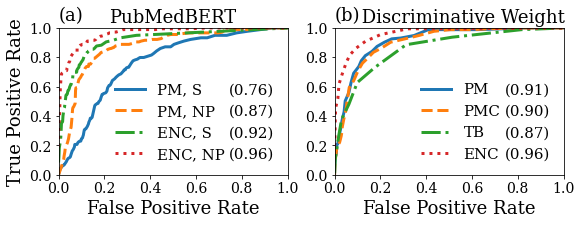

In [63]:
# Termhood score ROC plots + AUC
SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 18

dataset = "random_full"

plot_dict = {
#     "$n$-grams": {
#         "methods": [f"discriminative_weight-encyclopedia-(1, {value})-1" for value in (1, 2, 3)],
#         "ops": ["p=1_mean"],
#         "labels": ["$n$=1", "$n$=2", "$n$=3"],
#     },
#     "$p_p$-values": {
#         "methods": [f"discriminative_weight-encyclopedia-(1, 3)-{value}" for value in (1, 2, 5, 10, "inf")],
#         "ops": ["p=1_mean"],
#         "labels": ["1", "2", "5", "10", "$\infty$"],
#     },
#     "Operators": {
#         "methods": ["discriminative_weight-encyclopedia-(1, 3)-1"],
#         "ops": ["and"] + [f"p={value}_mean" for value in (1, 2, 5, 10, "inf")],
#         "labels": ["AND", "1", "2", "5", "10", "$\infty$"],
#         "x_lim": (0.0, 0.6),
#         "y_lim": (0.4, 1.0),
#     },
    "PubMedBERT": {
        "methods": [f"health_bert-pubmedbert-{corpus}-{text_format}" for corpus in ["pubmed", "encyclopedia"] for text_format in ["sentence", "noun_phrase"]],
        "ops": ["p=inf_mean"],
        "labels": ["PM, S", "PM, NP", "ENC, S", "ENC, NP"],
#         "x_lim": (0.0, 0.6),
#         "y_lim": (0.4, 1.0),
        "dataset": "sentence",
    },
    "     Discriminative Weight": {
        "methods": [f"discriminative_weight-{corpus}-(1, 1)-1" for corpus in ["pubmed", "pubmed_central", "textbook", "encyclopedia"]],
        "ops": ["p=1_mean"],
        "labels": ["PM", "PMC", "TB", "ENC"],
        "dataset": "random_full"
#         "x_lim": (0.0, 0.6),
#         "y_lim": (0.4, 1.0),
    },
}

num_plots = len(plot_dict)
fig, axes = plt.subplots(1, ncols=num_plots, figsize=(4 * num_plots, 3))
for idx, (ax, (title, kwargs)) in enumerate(zip(axes, plot_dict.items())):
    fig, aucs = auc_roc_curve(ax=ax, **kwargs)
    for auc in aucs:
        ax.plot([0, 1], [0, 1], alpha=0.0, label=f"({auc:.2f})")
    _text = ax.text(0, 1.05, f"({chr(97 + idx)})", transform=ax.transAxes, size=LARGE_SIZE)
    if idx % 2 == 1:
        _text.set_in_layout(False)
    print(aucs)
    ax.set_xlabel(ax.get_xlabel(), size=LARGE_SIZE)
    ax.set_title(title, size=LARGE_SIZE)
    legend = ax.legend(fontsize=15, framealpha=0.0, ncol=2, columnspacing=-2.5)
    ax.tick_params(labelsize=SMALL_SIZE)

# set y_label
axes[0].set_ylabel("True Positive Rate", size=LARGE_SIZE)
    
plt.tight_layout(pad=0.2)
fig.savefig("figures/roc_curves.pdf", bbox_inches="tight")

In [55]:
all_plot_ops = ["and", "or"] + [f"p={value}_mean" for value in (1, 2, 5, 10, "inf")]
all_plot_op_labels = ["And", "Or", "p=1", "p=2", "p=5", "p=10", "p=inf"]
all_p_value_labels = [f"p={p_value}" for p_value in p_values]
plot_dict = {
    "umls-subset": {
        "methods": ["mesh_1.0", "mesh_syn_1.0", "umls_1.0"],
        "plot_ops": ["and"],
        "labels": ["MeSH", "MeSH Syn", "UMLS"],
    },
    "jaccard-threshold": {
        "methods": [
            f"mesh_syn_{jaccard_threshold}"
            for jaccard_threshold in jaccard_thresholds
            if len(str(jaccard_threshold))
        ][::-1],
        "plot_ops": ["and"],
        "labels": [
            str(jaccard_threshold)
            for jaccard_threshold in jaccard_thresholds
            if len(str(jaccard_threshold))
        ][::-1][::-1],
    },
    "mesh-syn-operator": {
        "methods": ["mesh_syn_1.0"],
        "plot_ops": all_plot_ops,
        "labels": all_plot_op_labels,
    },
    "approach": {
        "methods": [
            "mesh_syn_1.0",
            "contrastive_weight_pubmed_(1, 1)_1",
            "term_domain_specificity_pubmed_(1, 1)_1",
            "discriminative_weight_pubmed_(1, 1)_1",
        ],
        "plot_ops": ["and"],
        "labels": [
            "MeSH Syn",
            "Contrastive Weight",
            "Term Domain Specificity",
            "Discriminative Weight",
        ],
    },
    "discriminative-weight-corpora": {
        "methods": [
            f"discriminative_weight_{corpus}_(1, 1)_1" for corpus in medical_corpora
        ],
        "plot_ops": ["and"],
        "labels": [" ".join(corpus.split("_")).title() for corpus in medical_corpora],
    },
    "discriminative-weight-operator": {
        "methods": ["discriminative_weight_encyclopedia_(1, 1)_1"],
        "plot_ops": all_plot_ops,
        "labels": all_plot_op_labels,
    },
    "discriminative-weight-generalized-mean": {
        "methods": [
            f"discriminative_weight_encyclopedia_(1, 1)_{p_value}"
            for p_value in p_values
        ],
        "plot_ops": ["p=1_mean"],
        "labels": all_p_value_labels,
    },
    "discriminative-weight-n-gram": {
        "methods": [
            "discriminative_weight_encyclopedia_(1, 1)_1",
            "discriminative_weight_encyclopedia_(1, 2)_1",
            "discriminative_weight_encyclopedia_(1, 3)_1",
        ],
        "plot_ops": ["p=1_mean"],
        "labels": ["(1, 1)", "(1, 2)", "(1, 3)"],
    },
}
datasets = ["random_full", "wikidata"]
for dataset in datasets:
    for name, plot_values in plot_dict.items():
        print(name)
        fig = precision_recall_plot(dataset=dataset, **plot_values)
        fig.savefig(f"figures/{dataset}-{name}-comparison.pdf", bbox_inches="tight")
        fig.clear(True)

umls-subset
jaccard-threshold
mesh-syn-operator
approach
discriminative-weight-corpora
discriminative-weight-operator
discriminative-weight-generalized-mean
discriminative-weight-n-gram
umls-subset
jaccard-threshold
mesh-syn-operator
approach
discriminative-weight-corpora
discriminative-weight-operator
discriminative-weight-generalized-mean
discriminative-weight-n-gram


<Figure size 576x288 with 0 Axes>

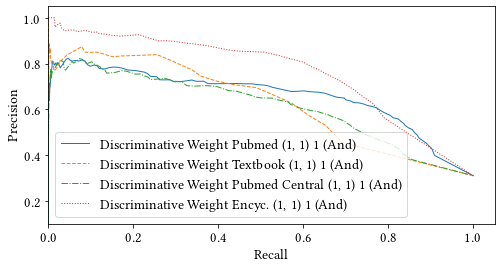

In [52]:
# methods = ["mesh_1.0", "mesh_syn_1.0", "umls_1.0"]
# methods = [f"mesh_syn_{jaccard_threshold}" for jaccard_threshold in jaccard_thresholds if len(str(jaccard_threshold))][::-1]
# methods = ["mesh_syn_1.0"]
# methods = ["mesh_syn_1.0", "contrastive_weight_pubmed_(1, 1)_1", "term_domain_specificity_pubmed_(1, 1)_1", "discriminative_weight_pubmed_(1, 1)_1"]
methods = [f"discriminative_weight_{corpus}_(1, 1)_1" for corpus in medical_corpora]
# methods = ["discriminative_weight_encyclopedia_(1, 1)_1"]
# methods = [f"discriminative_weight_encyclopedia_(1, 1)_{p_value}" for p_value in p_values]
# methods = ["discriminative_weight_encyclopedia_(1, 1)_1", "discriminative_weight_encyclopedia_(1, 2)_1"]
# methods = ["discriminative_weight_encyclopedia_(1, 1)_1"]


# plot_ops = ["and", "or", "arithmetic_mean", "quadratic_mean"]
# plot_ops = ["and", "arithmetic_mean", "quadratic_mean"]
# plot_ops = ["and", "or", "arithmetic_mean"]
# plot_ops = ["and", "arithmetic_mean"]
# plot_ops = ["arithmetic_mean"]
plot_ops = ["and"]
# plot_ops = ["or"]
dataset = "wikidata"
fig = precision_recall_plot(methods, plot_ops, dataset)

In [60]:
name = "discriminative-weight-corpus"
fig.savefig(f"figures/{name}-comparison.pdf", bbox_inches="tight")

In [56]:
def best_approach(
    validation_metrics,
    test_metrics,
    patterns,
    datasets,
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    macro,
    return_val=False,
):
    best_approaches = []

    def best_run(df):
        if threshold_score:
            if ((df[threshold_score] < threshold) | df[threshold_score].isna()).all():
                df = df.sort_values(threshold_score, ascending=False).iloc[[0]]
            else:
                df = df.loc[df[threshold_score] >= threshold]
        df = df.sort_values(optimization_score, ascending=False).iloc[0]
        df = df.map(lambda x: round(x, 4) if isinstance(x, (float)) else x)
        return df

    for pattern in patterns:
        tmp = validation_metrics.loc[validation_metrics.method.str.contains(pattern)]
        if datasets:
            tmp = tmp.loc[tmp.dataset.isin(datasets)]
        print(tmp.loc[~tmp.operator.isin(eval_ops)])
        if eval_ops:
            tmp = tmp.loc[tmp.operator.isin(eval_ops)]

        best_runs = tmp.groupby("dataset").apply(best_run)
        best_approaches.append(best_runs)

    idcs = np.tile(np.arange(len(patterns)), len(datasets)) * len(datasets) + np.repeat(
        np.arange(len(datasets)), len(patterns)
    )
    best_approaches = (
        pd.concat(best_approaches).reset_index(drop=True).iloc[idcs].reset_index()
    )

    if macro:
        for pattern in patterns:
            tmp = validation_metrics.loc[validation_metrics.method.str.contains(pattern)]
            if datasets:
                tmp = tmp.loc[tmp.dataset.isin(datasets)]
            if eval_ops:
                tmp = tmp.loc[tmp.operator.isin(eval_ops)]
            tmp = tmp.groupby(["method", "operator", "threshold"]).mean().reset_index()
            _best_run = best_run(tmp)
            _best_run["dataset"] = "macro"
            best_approaches = pd.concat([best_approaches, _best_run])

    best_approaches = best_approaches.drop("index", axis=1)
    best_approaches = best_approaches.reset_index(drop=True)
    best_approaches["method_class"] = best_approaches.method.apply(lambda x: x.split("-")[0])
    best_approaches.loc[best_approaches.method_class == "health_bert", "method_class"] = best_approaches.loc[best_approaches.method_class == "health_bert"].method.apply(lambda x: x.split("-")[1])
    validation_best_approaches = best_approaches.copy()
    test_best_approaches = best_approaches.merge(test_metrics, how="left", on=["dataset", "method", "operator", "threshold"], suffixes=("_to_drop", ""))
    test_best_approaches = test_best_approaches.drop(test_best_approaches.filter(like="_to_drop"), axis=1)
    if return_val:
        return validation_best_approaches, test_best_approaches
    return test_best_approaches

In [57]:
patterns = [
    "quickumls",
    "scispacy",
    "ctakes",
    "metamap",
    "-bert",
    "scibert",
    "pubmedbert",
    "contrastive",
    "specificity",
    "discriminative",
]
# patterns = ["mesh_[0-9]", "mesh_syn_[0-9]", "umls_[0-9]", "contrastive_weight_1", "term_domain_specificity_1", "discriminative_weight_1"]
# patterns = ["discriminative_weight_pubmed_(1, 2)_1"]
# patterns = ["contrastive", "specificity", "discriminative"]
threshold_score = "precision"
threshold = 0.9
optimization_score = "recall"
datasets = [
    "random_full",
    "random_support",
    "sentence",
]
macro = False
eval_ops = (
    ["p=0_mean"]
    + [f"p={p}_mean" for p in (1, 2, 5, 10, "inf")]
    + [f"p=neg_{p}_mean" for p in (1, 2, 5, 10, "inf")]
)

validation_best_approaches, test_best_approaches = best_approach(
    validation_causenet_metrics,
    test_causenet_metrics,
    patterns,
    datasets,
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    macro,
    return_val=True
)

if threshold_score:
    validation_best_approaches.to_csv(f"validation_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")
    test_best_approaches.to_csv(f"test_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")
else:
    validation_best_approaches.to_csv(f"validation_best_approaches_{optimization_score}.csv")
    test_best_approaches.to_csv(f"test_best_approaches_{optimization_score}.csv")
test_best_approaches

Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, accuracy, mcc]
Index: []
Empty DataFrame
Columns: [dataset, method, operator, threshold, tp, fp, tn, fn, precision, recall, f1, a

,dataset,method,operator,threshold,method_class,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc
0,random_full,quickumls-rx_sno-0.8-st21pv,p=neg_1_mean,0.6061,quickumls,0.0,4.0,157.0,39.0,0.0,0.0,NaN,0.785,-0.070311
1,random_full,scispacy-rx_sno-en_core_sci_sm-0.9-st21pv,p=neg_inf_mean,0.202,scispacy,0.0,5.0,156.0,39.0,0.0,0.0,NaN,0.78,-0.078811
2,random_full,ctakes-rx_sno-st21pv,p=neg_2_mean,0.6162,ctakes,0.0,3.0,158.0,39.0,0.0,0.0,NaN,0.79,-0.060736
3,random_full,metamap-rx_sno-st21pv,p=neg_inf_mean,0.6667,metamap,2.0,1.0,160.0,37.0,0.666667,0.051282,0.095238,0.81,0.146909
4,random_full,health_bert-bert-encyclopedia-noun_phrase,p=1_mean,0.7677,bert,30.0,3.0,158.0,9.0,0.909091,0.769231,0.833333,0.94,0.801193
5,random_full,health_bert-scibert-encyclopedia-noun_phrase,p=5_mean,0.7374,scibert,30.0,2.0,159.0,9.0,0.9375,0.769231,0.84507,0.945,0.817903
6,random_full,health_bert-pubmedbert-encyclopedia-noun_phrase,p=2_mean,0.7778,pubmedbert,32.0,2.0,159.0,7.0,0.941176,0.820513,0.876712,0.955,0.852338
7,random_full,"contrastive_weight-encyclopedia-(1, 2)-2",p=neg_1_mean,62.7273,contrastive_weight,28.0,5.0,156.0,11.0,0.848485,0.717949,0.777778,0.92,0.733194
8,random_full,"term_domain_specificity-encyclopedia-(1, 2)-1",p=1_mean,1.5758,term_domain_specificity,27.0,0.0,161.0,12.0,1.0,0.692308,0.818182,0.94,0.802674
9,random_full,"discriminative_weight-encyclopedia-(1, 1)-1",p=1_mean,100.0,discriminative_weight,29.0,0.0,161.0,10.0,1.0,0.74359,0.852941,0.95,0.836723


In [38]:
tmp = validation_causenet_metrics.loc[(validation_causenet_metrics.dataset == "random_full") & validation_causenet_metrics.method.str.contains("discri")]
# tmp = tmp.loc[tmp.precision > 0.9].sort_values("recall")
tmp

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc
1056000,random_full,"discriminative_weight-encyclopedia-(1, 1)-0",p=0,0.0,175.0,625.0,0.0,0.0,0.21875,1.0,0.358974,0.21875,NaN
1056003,random_full,"discriminative_weight-encyclopedia-(1, 1)-0",p=10_mean,0.0,175.0,625.0,0.0,0.0,0.21875,1.0,0.358974,0.21875,NaN
1056006,random_full,"discriminative_weight-encyclopedia-(1, 1)-0",p=1_mean,0.0,175.0,625.0,0.0,0.0,0.21875,1.0,0.358974,0.21875,NaN
1056009,random_full,"discriminative_weight-encyclopedia-(1, 1)-0",p=2_mean,0.0,175.0,625.0,0.0,0.0,0.21875,1.0,0.358974,0.21875,NaN
1056012,random_full,"discriminative_weight-encyclopedia-(1, 1)-0",p=5_mean,0.0,175.0,625.0,0.0,0.0,0.21875,1.0,0.358974,0.21875,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491585,random_full,"discriminative_weight-textbook-(1, 3)-neg_inf",p=neg_10_mean,1100.0,0.0,0.0,625.0,175.0,NaN,0.0,NaN,0.78125,NaN
1491588,random_full,"discriminative_weight-textbook-(1, 3)-neg_inf",p=neg_1_mean,1100.0,0.0,0.0,625.0,175.0,NaN,0.0,NaN,0.78125,NaN
1491591,random_full,"discriminative_weight-textbook-(1, 3)-neg_inf",p=neg_2_mean,1100.0,0.0,0.0,625.0,175.0,NaN,0.0,NaN,0.78125,NaN
1491594,random_full,"discriminative_weight-textbook-(1, 3)-neg_inf",p=neg_5_mean,1100.0,0.0,0.0,625.0,175.0,NaN,0.0,NaN,0.78125,NaN


In [21]:
validation_best_approaches

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc,method_class
0,random_full,quickumls-rx_sno-0.8-st21pv,p=neg_1_mean,0.6061,6.0,0.0,625.0,169.0,1.0000,0.0343,0.0663,0.7887,0.1643,quickumls
1,random_full,scispacy-rx_sno-en_core_sci_sm-0.9-st21pv,p=neg_inf_mean,0.202,5.0,0.0,625.0,170.0,1.0000,0.0286,0.0556,0.7875,0.1499,scispacy
2,random_full,ctakes-rx_sno-st21pv,p=neg_2_mean,0.6162,4.0,0.0,625.0,171.0,1.0000,0.0229,0.0447,0.7862,0.1340,ctakes
3,random_full,metamap-rx_sno-st21pv,p=neg_inf_mean,0.6667,2.0,0.0,625.0,173.0,1.0000,0.0114,0.0226,0.7837,0.0946,metamap
4,random_full,health_bert-bert-encyclopedia-noun_phrase,p=1_mean,0.7677,127.0,14.0,611.0,48.0,0.9007,0.7257,0.8038,0.9225,0.7631,bert
5,random_full,health_bert-scibert-encyclopedia-noun_phrase,p=5_mean,0.7374,126.0,14.0,611.0,49.0,0.9000,0.7200,0.8000,0.9212,0.7590,scibert
6,random_full,health_bert-pubmedbert-encyclopedia-noun_phrase,p=2_mean,0.7778,128.0,13.0,612.0,47.0,0.9078,0.7314,0.8101,0.9250,0.7710,pubmedbert
7,random_full,"contrastive_weight-encyclopedia-(1, 2)-2",p=neg_1_mean,62.7273,95.0,10.0,615.0,80.0,0.9048,0.5429,0.6786,0.8875,0.6450,contrastive_weight
8,random_full,"term_domain_specificity-encyclopedia-(1, 2)-1",p=1_mean,1.5758,109.0,12.0,613.0,66.0,0.9008,0.6229,0.7365,0.9025,0.6965,term_domain_specificity
9,random_full,"discriminative_weight-encyclopedia-(1, 1)-1",p=1_mean,100.0,108.0,12.0,613.0,67.0,0.9000,0.6171,0.7322,0.9012,0.6923,discriminative_weight


In [125]:
threshold_score = "recall"
threshold = 0.9
optimization_score = "precision"
pd.read_csv(f"validation_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")

,Unnamed: 0,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc,method_class
0,0,random_full,quickumls-rx_sno-0.8,p=2_mean,0.4949,158.0,278.0,347.0,17.0,0.3624,0.9029,0.5172,0.6312,0.3803,quickumls
1,1,random_full,scispacy-full-en_core_sci_lg-0.6,p=2_mean,0.7879,158.0,340.0,285.0,17.0,0.3173,0.9029,0.4695,0.5538,0.3060,scispacy
2,2,random_full,ctakes-rx_sno,p=2_mean,0.3131,159.0,363.0,262.0,16.0,0.3046,0.9086,0.4562,0.5262,0.2846,ctakes
3,3,random_full,metamap-rx_sno,p=2_mean,0.7273,158.0,224.0,401.0,17.0,0.4136,0.9029,0.5673,0.6988,0.4506,metamap
4,4,random_full,health_bert-bert-encyclopedia-noun_phrase,p=5_mean,0.7374,159.0,52.0,573.0,16.0,0.7536,0.9086,0.8238,0.9150,0.7743,bert
5,5,random_full,health_bert-scibert-encyclopedia-noun_phrase,p=2_mean,0.5859,158.0,58.0,567.0,17.0,0.7315,0.9029,0.8082,0.9062,0.7543,scibert
6,6,random_full,health_bert-pubmedbert-encyclopedia-noun_phrase,p=1_mean,0.6061,159.0,51.0,574.0,16.0,0.7571,0.9086,0.8260,0.9162,0.7770,pubmedbert
7,7,random_full,"contrastive_weight-encyclopedia-(1, 3)-5",p=2_mean,59.0909,160.0,98.0,527.0,15.0,0.6202,0.9143,0.7390,0.8588,0.6699,contrastive_weight
8,8,random_full,"term_domain_specificity-encyclopedia-(1, 2)-0",p=neg_1_mean,0.4242,161.0,75.0,550.0,14.0,0.6822,0.9200,0.7835,0.8888,0.7252,term_domain_specificity
9,9,random_full,"discriminative_weight-encyclopedia-(1, 3)-1",p=inf_mean,55.5556,158.0,72.0,553.0,17.0,0.6870,0.9029,0.7802,0.8888,0.7194,discriminative_weight


In [ ]:
def mcc(samples, labels):
    tp = (samples & labels).sum()
    tn = (~samples & ~labels).sum()
    fp = (samples & ~labels).sum()
    fn = (~samples & labels).sum()
    numerator = tp * tn - fp * fn
    denominator = np.log([tp + fp, tp + fn, tn + fp, tn + fn]).sum() * (1 / 2)
    mcc = numerator / np.exp(denominator)
    return mcc

def precision(samples, labels):
    tp = (samples & labels).sum()
    fp = (samples & ~labels).sum()
    return tp / (tp + fp)

def recall(samples, labels):
    tp = (samples & labels).sum()
    fn = (~samples & labels).sum()
    return tp / (tp + fn)


def bootstrap(sample_x, sample_y, labels, metric, n):
    base_value = metric(sample_x, labels) - metric(sample_y, labels)
    pooled = list(sample_x) + list(sample_y)
    num_samples = len(pooled) // 2
    metrics = []
    for _ in tqdm(range(n), position=3, leave=False):
        permutation = np.random.permutation(pooled)
        sampled_x = permutation[:num_samples]
        sampled_y = permutation[num_samples:]
        sampled_metric = metric(sampled_x, labels) - metric(sampled_y, labels)
        metrics.append(sampled_metric)
    metrics = np.array(metrics)
    percentile = sum(base_value > metrics) / n
    return percentile

def significance_test(df, optimization_func, n=5000):
    rows = df.method.apply(lambda x: x.split("-")[0])
    percentiles = pd.DataFrame(np.nan, index=rows, columns=rows)
    name = df.name
    if df.name not in test_causenet.dataset.unique().tolist():
        return percentiles
#     print(f"{name:<30}", end="\r")
    df = df.copy()
    df["approach_name"] = (
        df.method + "-" + df.operator + "-" + df.threshold.astype(str) + "-medical"
    )
    value_bool = (test_causenet.dataset == name)
    for approach_1_idx, (_, approach_1) in tqdm(list(enumerate(df.iterrows())), position=1, leave=False):
        samples_1 = test_causenet_medical.loc[value_bool, approach_1.approach_name].values
        for approach_2_idx, (_, approach_2) in tqdm(list(enumerate(df.iterrows())), position=2, leave=False):
            if approach_1_idx >= approach_2_idx:
                continue
            samples_2 = test_causenet_medical.loc[value_bool, approach_2.approach_name].values
            percentile = bootstrap(
                samples_1, samples_2, test_causenet.loc[value_bool, "evaluation"], optimization_func, n
            )
            percentiles.iloc[approach_1_idx, approach_2_idx] = percentile
            percentiles.iloc[approach_2_idx, approach_1_idx] = 1 - percentile
    return percentiles


n = 100000
threshold_score = ""
threshold = 0.9
optimization_score = "mcc"
if threshold_score:
    significance_approaches = pd.read_csv(f"test_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")
else:
    significance_approaches = pd.read_csv(f"test_best_approaches_{optimization_score}.csv")


if optimization_score == "precision":
    optimization_func = precision
elif optimization_score == "recall":
    optimization_func = recall
elif optimization_score == "mcc":
    optimization_func = mcc
else:
    optimization_func = None
    
significance = (
    significance_approaches.groupby("dataset")
    .progress_apply(lambda x: significance_test(x, optimization_func, n=n))
    .drop("macro", level=0, errors="ignore")
)

if threshold_score:
    significance.to_csv(f"significance_{optimization_score}_{threshold_score}_{threshold}.csv")
else:
    significance.to_csv(f"significance_{optimization_score}.csv")
significance

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [39]:
precision_significance = pd.read_csv("significance_recall_precision_0.9.csv", index_col=[0, 1])
precision_significance.loc["wikidata", "discriminative_weight"]

quickumls                  0.00000
scispacy                   1.00000
ctakes                     0.00000
metamap                    0.00000
health_bert                0.80804
health_bert.1              1.00000
health_bert.2              1.00000
contrastive_weight         1.00000
term_domain_specificity    1.00000
discriminative_weight          NaN
Name: (wikidata, discriminative_weight), dtype: float64

In [30]:
recall_significance = pd.read_csv("significance_precision_recall_0.9.csv", index_col=[0, 1])
recall_significance.loc["wikidata", "pmbert"]

quickumls                  1.00000
scispacy                   1.00000
ctakes                     1.00000
metamap                    1.00000
health_bert                0.99707
health_bert.1              0.99986
health_bert.2                  NaN
contrastive_weight         1.00000
term_domain_specificity    0.53193
discriminative_weight      0.98839
Name: (wikidata, pmbert), dtype: float64

In [25]:
mcc_significance = pd.read_csv("significance_mcc.csv", index_col=[0, 1])
mcc_significance.loc["wikidata", "pmbert"]

quickumls                  1.00
scispacy                   1.00
ctakes                     1.00
metamap                    1.00
health_bert                0.88
health_bert.1              1.00
health_bert.2               NaN
contrastive_weight         1.00
term_domain_specificity    0.98
discriminative_weight      0.97
Name: (wikidata, pmbert), dtype: float64

In [10]:
def pprint(
    values,
    bold=False,
    bold_axis=0,
    bold_command="\highlight",
    bold_idcs=None,
    round_to=2,
    direction="maximize",
):
    for row_idx, row in enumerate(values):
        for col_idx, value in enumerate(row):
            try:
                float(value)
                values[row_idx, col_idx] = round(float(value), round_to)
            except ValueError:
                pass
    if bold_idcs is None:
        bold_idcs = []
    for idx, bold_idx in enumerate(bold_idcs):
        if bold_idx < 0:
            bold_idcs[idx] = values.shape[1 - bold_axis] + bold_idx
    if bold:
        if bold_axis not in (0, 1):
            raise ValueError(f"invalid axis value, expected 0, 1, got {axis}")
        inf_value = float("-inf") if direction == "maximize" else float("inf")
        numerical_values = [
            [value if isinstance(value, (float, int)) else inf_value for value in row]
            for row in values
        ]
        if direction == "maximize":
            best_values = np.amax(numerical_values, axis=bold_axis)
        else:
            best_values = np.amin(numerical_values, axis=bold_axis)
        if bold_axis == 1:
            values = values.T
        for row_idx, row in enumerate(values):
            for col_idx, value in enumerate(row):
                if (
                    bold_axis == 0
                    and values[row_idx][col_idx] == best_values[col_idx]
                    and col_idx in bold_idcs
                ) or (
                    bold_axis == 1
                    and values[row_idx][col_idx] == best_values[row_idx]
                    and row_idx in bold_idcs
                ):
                    string_value = str(value)
                    string_value += "0" * (round_to - len(string_value) + 2)
                    values[row_idx][col_idx] = f"{bold_command}{{{string_value}}}"
        if bold_axis == 1:
            values = values.T

    string_values = []
    for row in values:
        row_string_values = []
        for value in row:
            try:
                float(value)
                string_value = str(value)
                string_value += "0" * (round_to - len(string_value) + 2)
                row_string_values.append(string_value)
            except ValueError:
                row_string_values.append(str(value))
        string_values.append(row_string_values)

    out = " \\\\\n".join(" & ".join(values) for values in string_values)
    out += " \\\\"

    print(out)
    
    return out


def small(string):
    return f"\small{{{string}}}"


def scriptsize(string):
    return f"\scriptsize{{{string}}}"


def tiny(string):
    return f"\\tiny{{{string}}}"


def rename_method(method_name, parameters=True):

    name_dict = {
        "pubmedbert": "PubMedBERT",
        "scibert": "SciBERT",
        "bert": "BERT",
        "mesh": "MeSH",
        "quickumls": "QuickUMLS",
        "umls": "UMLS",
        "contrastive_weight": "CW",
        "term_domain_specificity": "TDS",
        "discriminative_weight": "DW",
        "encyclopedia": "ENC",
        "pubmed": "PM",
        "ctakes": "cTakes",
        "metamap": "MetaMap",
        "scispacy": "ScispaCy",
        "en_core_sci_": "",
        "rx_sno": "RS",
        "full": "Full",
        "noun_phrase": "NP",
        "sentence": "S",
    }

    for name, replace_name in name_dict.items():
        method_name = method_name.replace(name, replace_name)
    method_split = method_name.split("-")
    params = []
    if "CW" in method_name or "DW" in method_name or "TDS" in method_name:
        name = method_split[0]
        if parameters:
            try:
                method_split[-2] = (
                    "$n$=" + method_split[-2].strip("()").split(",")[1].strip()
                )
                method_split[-1] = f"$M_{{{method_split[-1]}}}$"
                params = method_split[1:]
            except IndexError:
                pass
    elif "ScispaCy" in method_name:
        name = method_split[0]
        if parameters:
            try:
                params = [method_split[1], f"\\textit{{{method_split[2]}}}", method_split[3]]
            except IndexError:
                pass
    elif "health_BERT" in method_name:
        name = method_split[1]
        if parameters:
            params = method_split[2:]
    else:
        name = method_split[0] 
        if parameters:
            params = method_split[1:] 
    if params:
        name += " " + scriptsize(", ".join(params))
    return name


def rename_operator(operator_name):
    operator_name = operator_name.replace("inf", "\infty").replace("neg_", "-")
    value = operator_name.split("=")[1].split("_")[0]
    if value[0] == "-":
        value = r"\texttt{--}\!" + value[1:]
    return f"$M_{{{value}}}$"

In [28]:
dataset = "random_full"
# dataset = "random_support"
# dataset = "sentence"
# dataset = "wikidata"
# dataset = "practitioner_full"
# dataset = "practitioner_sure"
# dataset = "practitioner_unsure"

approaches = [
    "ctakes",
    "metamap",
    "quickumls",
    "scispacy",
    "health_bert",
    "contrastive",
    "specificity",
    "discriminative",
]


def key(series):
    order = pd.Series(-1, index=series.index)
    for idx, approach in enumerate(approaches):
        order[series.str.contains(approach)] = idx
    return order


threshold_score = "precision"
threshold = 0.9
optimization_score = "recall"
if threshold_score:
    pretty_print_approaches = pd.read_csv(f"test_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")
else:
    pretty_print_approaches = pd.read_csv(f"test_best_approaches_{optimization_score}.csv")
pretty_print_approaches["pretty_method"] = pretty_print_approaches.method.map(
    rename_method
)
pretty_print_approaches["pretty_operator"] = pretty_print_approaches.operator.map(
    rename_operator
)

pretty_print_approaches = pretty_print_approaches.loc[
    pretty_print_approaches.dataset == dataset
]
pretty_print_approaches = pretty_print_approaches.loc[
    key(pretty_print_approaches.method) != -1
]
pretty_print_approaches = pretty_print_approaches.sort_values(by="method", key=key)

pprint(
    pretty_print_approaches.loc[
        :, [
            "pretty_method", 
            "pretty_operator", 
            "precision", 
            "recall", 
#             "f1", 
#             "mcc"
        ]
    ].values,
    bold=True,
    bold_idcs=[-1, -2, -3, -4],
)

cTakes \scriptsize{RS, st21pv} & $M_{\texttt{--}\!2}$ & 0.00 & 0.00 \\
MetaMap \scriptsize{RS, st21pv} & $M_{\texttt{--}\!\infty}$ & 0.67 & 0.05 \\
QuickUMLS \scriptsize{RS, 0.8, st21pv} & $M_{\texttt{--}\!1}$ & 0.00 & 0.00 \\
ScispaCy \scriptsize{RS, \textit{sm}, 0.9} & $M_{\texttt{--}\!\infty}$ & 0.00 & 0.00 \\
BERT \scriptsize{ENC, NP} & $M_{1}$ & 0.91 & 0.77 \\
SciBERT \scriptsize{ENC, NP} & $M_{5}$ & 0.94 & 0.77 \\
PubMedBERT \scriptsize{ENC, NP} & $M_{2}$ & 0.94 & \highlight{0.82} \\
CW \scriptsize{ENC, $n$=2, $M_{2}$} & $M_{\texttt{--}\!1}$ & 0.85 & 0.72 \\
TDS \scriptsize{ENC, $n$=2, $M_{1}$} & $M_{1}$ & \highlight{1.00} & 0.69 \\
DW \scriptsize{ENC, $n$=1, $M_{1}$} & $M_{1}$ & \highlight{1.00} & 0.74 \\


'cTakes \\scriptsize{RS, st21pv} & $M_{\\texttt{--}\\!2}$ & 0.00 & 0.00 \\\\\nMetaMap \\scriptsize{RS, st21pv} & $M_{\\texttt{--}\\!\\infty}$ & 0.67 & 0.05 \\\\\nQuickUMLS \\scriptsize{RS, 0.8, st21pv} & $M_{\\texttt{--}\\!1}$ & 0.00 & 0.00 \\\\\nScispaCy \\scriptsize{RS, \\textit{sm}, 0.9} & $M_{\\texttt{--}\\!\\infty}$ & 0.00 & 0.00 \\\\\nBERT \\scriptsize{ENC, NP} & $M_{1}$ & 0.91 & 0.77 \\\\\nSciBERT \\scriptsize{ENC, NP} & $M_{5}$ & 0.94 & 0.77 \\\\\nPubMedBERT \\scriptsize{ENC, NP} & $M_{2}$ & 0.94 & \\highlight{0.82} \\\\\nCW \\scriptsize{ENC, $n$=2, $M_{2}$} & $M_{\\texttt{--}\\!1}$ & 0.85 & 0.72 \\\\\nTDS \\scriptsize{ENC, $n$=2, $M_{1}$} & $M_{1}$ & \\highlight{1.00} & 0.69 \\\\\nDW \\scriptsize{ENC, $n$=1, $M_{1}$} & $M_{1}$ & \\highlight{1.00} & 0.74 \\\\'

In [37]:
precision_threshold = 0.0
dataset = "random_full"
linker_approaches = pd.read_csv(
    f"best_approaches_{precision_threshold}.csv", index_col=0
)
linker_approaches = linker_approaches.loc[linker_approaches.dataset == dataset].iloc[:4]
linker_predictions = []
for _, method, operator, threshold, *_ in linker_approaches.values:
    label = "-".join([method, operator, str(threshold), "medical"])
    linker_predictions.append(
        test_causenet_medical.loc[test_causenet.dataset == dataset, label]
    )
linker_predictions = pd.concat(linker_predictions, axis=1)
for threshold in range(1, 5):
    combined_predictions = linker_predictions.sum(axis=1) >= threshold
    tp = (
        combined_predictions
        & test_causenet.evaluation.loc[test_causenet.dataset == dataset]
    ).sum()
    tn = (
        ~combined_predictions
        & ~test_causenet.evaluation.loc[test_causenet.dataset == dataset]
    ).sum()
    fp = (
        combined_predictions
        & ~test_causenet.evaluation.loc[test_causenet.dataset == dataset]
    ).sum()
    fn = (
        ~combined_predictions
        & test_causenet.evaluation.loc[test_causenet.dataset == dataset]
    ).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(threshold, round(precision, 2), round(recall, 2), round(f1, 2), round(accuracy, 2))
linker_predictions.sum(axis=1).value_counts().sort_index()

1 0.4 0.93 0.56 0.69
2 0.49 0.81 0.61 0.78
3 0.52 0.65 0.58 0.8
4 0.67 0.46 0.55 0.84


0    504
1    142
2     83
3    124
4    147
dtype: int64

In [68]:
# ablation tests
threshold_score = "recall"
threshold = 0.9
optimization_score = "precision"
datasets = [
    "random_full",
    "random_support",
    "sentence",
#     "support",
#     "wikidata",
#     "practitioner_full",
#     "practitioner_sure",
#     "practitioner_unsure",
]
use_test_metrics = True
full_train = True
if use_test_metrics:
    ablation_test_metrics = test_causenet_metrics
    ablation_set = "test"
else:
    ablation_test_metrics = None
    ablation_set = "validation"
val_causenet = validation_causenet_metrics.loc[:, ["dataset", "method", "operator"]].drop_duplicates()
val_causenet["method_class"] = val_causenet["method"].map(lambda x: x.split("-")[0])


if threshold_score:
    ablation_best_approaches = pd.read_csv(f"{ablation_set}_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv", index_col=0)
else:
    ablation_best_approaches = pd.read_csv(f"{ablation_set}_best_approaches_{optimization_score}.csv", index_col=0)

ablation_best_approaches = ablation_best_approaches.loc[
    ablation_best_approaches.method_class.isin(["contrastive_weight", "discriminative_weight", "term_domain_specificity"]),
    ["dataset", "method", "operator", "method_class", optimization_score]
]
ablation_best_approaches = ablation_best_approaches.reset_index(drop=True)
ablation_methods = ablation_best_approaches.copy().drop(optimization_score, axis=1)
ablation_best_approaches = ablation_best_approaches.loc[:, ["dataset", "method_class", optimization_score]]

def get_ablation_df(ablation_df, validation_metrics, test_metrics=None):
    ablation_df = ablation_df.merge(validation_metrics.dropna())
    if threshold_score:
        ablation_df = ablation_df.loc[ablation_df[threshold_score] >= threshold]
    ablation_df = ablation_df.groupby(["dataset", "method_class"]).apply(lambda x: x.sort_values(optimization_score).iloc[-1]).reset_index(drop=True)
    if test_metrics is not None:
        ablation_df = ablation_df.merge(test_metrics, how="left", on=["dataset", "method", "operator", "threshold"], suffixes=("_to_drop", ""))
        ablation_df = ablation_df.drop(ablation_df.filter(like="_to_drop"), axis=1)
    ablation_df = ablation_df.loc[:, ["dataset", "method_class", optimization_score]]
    return ablation_df

if full_train:
    pattern = r".*-\(1, 1\)-.*"
    ablation_arithmetic_mean = get_ablation_df(
        val_causenet.loc[val_causenet.method.str.contains(pattern)],
        validation_causenet_metrics,
        test_causenet_metrics,
    )
else:
    ablation_arithmetic_mean = ablation_methods.copy()
    ablation_arithmetic_mean["method"] = ablation_arithmetic_mean["method"].map(lambda x: "-".join(x.split("-")[:-1]) + "-1")
    ablation_arithmetic_mean = get_ablation_df(ablation_arithmetic_mean, validation_causenet_metrics, test_causenet_metrics)
ablation_best_approaches = ablation_best_approaches.merge(ablation_arithmetic_mean, on=["dataset", "method_class"], suffixes=["", "-arithmetic_mean"], how="left")

if full_train:
    pattern = r".*-\(1, .\)-1"
    ablation_n_gram = get_ablation_df(
        val_causenet.loc[val_causenet.method.str.contains(pattern)],
        validation_causenet_metrics,
        test_causenet_metrics,
    )
else:
    ablation_n_gram = ablation_methods.copy()
    ablation_n_gram["method"] = ablation_n_gram["method"].map(lambda x: x.split(")")[0][:-1] + "1)" + x.split(")")[1])
    ablation_n_gram = get_ablation_df(ablation_n_gram, validation_causenet_metrics, test_causenet_metrics)
ablation_best_approaches = ablation_best_approaches.merge(ablation_n_gram, on=["dataset", "method_class"], suffixes=["", "-n_gram"], how="left")

# if full_train:
#     pattern = r".*-\(1, 1\)-1"
#     ablation_arithmetic_mean_n_gram = get_ablation_df(
#         val_causenet.loc[val_causenet.method.str.contains(pattern)],
#         validation_causenet_metrics,
#         test_causenet_metrics,
#     )
# else:
#     ablation_arithmetic_mean_n_gram = ablation_methods.copy()
#     ablation_arithmetic_mean_n_gram["method"] = ablation_arithmetic_mean_n_gram["method"].map(lambda x: x.split(")")[0][:-1] + "1)" + x.split(")")[1])
#     ablation_arithmetic_mean_n_gram["method"] = ablation_arithmetic_mean_n_gram["method"].map(lambda x: "-".join(x.split("-")[:-1]) + "-1")
#     ablation_arithmetic_mean_n_gram = get_ablation_df(ablation_arithmetic_mean_n_gram, validation_causenet_metrics, test_causenet_metrics)
# ablation_best_approaches = ablation_best_approaches.merge(ablation_arithmetic_mean_n_gram, on=["dataset", "method_class"], suffixes=["", "-arithmetic_mean_n_gram"], how="left")

ablation_best_approaches = ablation_best_approaches.merge(
    ablation_best_approaches.filter(like=f"{optimization_score}-").subtract(ablation_best_approaches[optimization_score].values, axis=0), 
    suffixes=["", "-reduction"],
    left_index=True,
    right_index=True,
)
ablation_best_approaches

,dataset,method_class,precision,precision-arithmetic_mean,precision-n_gram,precision-arithmetic_mean-reduction,precision-n_gram-reduction
0,random_full,contrastive_weight,0.580645,0.552239,0.552239,-0.028406,-0.028406
1,random_full,term_domain_specificity,0.666667,0.618182,0.7,-0.048485,0.033333
2,random_full,discriminative_weight,0.625000,0.580645,0.625,-0.044355,0.0
3,random_support,contrastive_weight,0.803150,0.80315,0.80315,0.0,0.0
4,random_support,term_domain_specificity,0.925926,0.935185,0.925926,0.009259,-0.0
5,random_support,discriminative_weight,0.927273,0.892857,0.927273,-0.034416,0.0
6,sentence,contrastive_weight,0.563636,0.563636,0.563636,0.0,0.0
7,sentence,term_domain_specificity,0.615385,0.615385,0.507937,0.0,-0.107448
8,sentence,discriminative_weight,0.591837,0.596154,0.566038,0.004317,-0.025799


In [69]:
print("\n", pprint(ablation_best_approaches.filter(like="-reduction").values))

-0.03 & -0.03 \\
-0.05 & 0.03 \\
-0.04 & 0.00 \\
0.00 & 0.00 \\
0.01 & -0.0 \\
-0.03 & 0.00 \\
0.00 & 0.00 \\
0.00 & -0.11 \\
0.00 & -0.03 \\

 -0.03 & -0.03 \\
-0.05 & 0.03 \\
-0.04 & 0.00 \\
0.00 & 0.00 \\
0.01 & -0.0 \\
-0.03 & 0.00 \\
0.00 & 0.00 \\
0.00 & -0.11 \\
0.00 & -0.03 \\


In [46]:
# ablation tests
threshold_score = ""
threshold = 0.0
optimization_score = "mcc"
datasets = [
    "random_full",
    "random_support",
    "sentence",
#     "support",
#     "wikidata",
    #     "practitioner_full",
    #     "practitioner_sure",
    #     "practitioner_unsure",
]
eval_ops = ["p=0_mean"] + [f"p={p}_mean" for p in (1, 2, 5, 10, "inf")] + [f"p=neg_{p}_mean" for p in (1, 2, 5, 10, "inf")]

patterns = [
    "contrastive_weight-.*-\(1, 1\)-.*",
    "term_domain_specificity-.*-\(1, 1\)-.*",
    "discriminative_weight-.*-\(1, 1\)-.*",
]
best_approaches_n_grams = best_approach(
    validation_causenet_metrics,
    test_causenet_metrics,
    patterns,
    datasets,
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    False,
)

patterns = [
    "contrastive_weight-.*-\(1, .\)-1",
    "term_domain_specificity-.*-\(1, .\)-1",
    "discriminative_weight-.*-\(1, .\)-1",
]
best_approaches_arithmetic_mean = best_approach(
    validation_causenet_metrics,
    test_causenet_metrics,
    patterns,
    datasets,
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    False,
)

# patterns = [
#     "contrastive_weight-.*-\(1, .\)-neg_inf",
#     "term_domain_specificity-.*-\(1, .\)-neg_inf",
#     "discriminative_weight-.*-\(1, .\)-neg_inf",
# ]
# best_approaches_and = best_approach(
#     validation_causenet_metrics,
#     test_causenet_metrics,
#     patterns,
#     datasets,
#     threshold_score,
#     threshold,
#     optimization_score,
#     eval_ops,
#     False,
# )

# patterns = [
#     "contrastive_weight-.*-\(1, .\)-inf",
#     "term_domain_specificity-.*-\(1, .\)-inf",
#     "discriminative_weight-.*-\(1, .\)-inf",
# ]
# best_approaches_or = best_approach(
#     validation_causenet_metrics,
#     test_causenet_metrics,
#     patterns,
#     datasets,
#     threshold_score,
#     threshold,
#     optimization_score,
#     eval_ops,
#     False,
# )

patterns = [
    "contrastive_weight-.*-\(1, 1\)-1",
    "term_domain_specificity-.*-\(1, 1\)-1",
    "discriminative_weight-.*-\(1, 1\)-1",
]
best_approaches_n_grams_arithmetic_mean = best_approach(
    validation_causenet_metrics,
    test_causenet_metrics,
    patterns,
    datasets,
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    False,
)

# patterns = [
# #     "metamap",
# #     "ctakes",
# #     "quickumls",
# #     "scispacy",
# #     "-bert",
# #     "scibert",
# #     "pubmedbert",
#     "contrastive_weight-.*-\(1, .\)-.*",
#     "term_domain_specificity-.*-\(1, .\)-.*",
#     "discriminative_weight-.*-\(1, .\)-.*",
# ]
# eval_ops = ["p=neg_inf_mean"]
# best_approaches_and_operator = best_approach(
#     validation_causenet_metrics,
#     test_causenet_metrics,
#     patterns,
#     [dataset for dataset in datasets if dataset != "sentence"],
#     threshold_score,
#     threshold,
#     optimization_score,
#     eval_ops,
#     False,
# )

# patterns = [
# #     "metamap",
# #     "ctakes",
# #     "quickumls",
# #     "scispacy",
# #     "-bert",
# #     "scibert",
# #     "pubmedbert",
#     "contrastive_weight-.*-\(1, .\)-.*",
#     "term_domain_specificity-.*-\(1, .\)-.*",
#     "discriminative_weight-.*-\(1, .\)-.*",
# ]
# eval_ops = ["p=inf_mean"]
# best_approaches_or_operator = best_approach(
#     validation_causenet_metrics,
#     test_causenet_metrics,
#     patterns,
#     [dataset for dataset in datasets if dataset != "sentence"],
#     threshold_score,
#     threshold,
#     optimization_score,
#     eval_ops,
#     False,
# )

patterns = [
#     "metamap",
#     "ctakes",
#     "quickumls",
#     "scispacy",
#     "-bert",
#     "scibert",
#     "pubmedbert",
    "contrastive_weight-.*-\(1, .\)-.*",
    "term_domain_specificity-.*-\(1, .\)-.*",
    "discriminative_weight-.*-\(1, .\)-.*",
]
eval_ops = ["p=1_mean"]
best_approaches_arithmetic_mean_operator = best_approach(
    validation_causenet_metrics,
    test_causenet_metrics,
    patterns,
    [dataset for dataset in datasets if dataset != "sentence"],
    threshold_score,
    threshold,
    optimization_score,
    eval_ops,
    False,
)

# patterns = [
#     "health_bert-.*-sentence",
# ]
# eval_ops = ["and"] + [f"p={p}_mean" for p in (1, 2, 5, 10, "inf")]
# best_approaches_sentence = best_approach(
#     test_causenet_metrics,
#     patterns,
#     datasets,
#     threshold_score,
#     threshold,
#     optimization_score,
#     eval_ops,
#     False,
# )

if threshold_score:
    best_approaches_comparison = pd.read_csv(f"test_best_approaches_{optimization_score}_{threshold_score}_{threshold}.csv")
else:
    best_approaches_comparison = pd.read_csv(f"test_best_approaches_{optimization_score}.csv")

best_approaches_comparison = best_approaches_comparison.loc[:, ["method_class", "dataset", optimization_score]]
best_approaches_comparison = best_approaches_comparison.merge(best_approaches_n_grams.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-n_grams"), how="inner")
# best_approaches_comparison = best_approaches_comparison.merge(best_approaches_and.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-and"), how="outer")
# best_approaches_comparison = best_approaches_comparison.merge(best_approaches_or.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-or"), how="outer")
# best_approaches_comparison = best_approaches_comparison.merge(best_approaches_and_operator.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-and_operator"), how="outer")
# best_approaches_comparison = best_approaches_comparison.merge(best_approaches_or_operator.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-or_operator"), how="outer")
best_approaches_comparison = best_approaches_comparison.merge(best_approaches_arithmetic_mean.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-arithmetic_mean"), how="outer")
best_approaches_comparison = best_approaches_comparison.merge(best_approaches_n_grams_arithmetic_mean.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-n_grams_arithmetic_mean"), how="outer")
best_approaches_comparison = best_approaches_comparison.merge(best_approaches_arithmetic_mean_operator.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-arithmetic_mean_operator"), how="outer")
# best_approaches_comparison = best_approaches_comparison.merge(best_approaches_sentence.loc[:, ["method_class", "dataset", optimization_score]], on=["method_class", "dataset"], suffixes=("", "-sentence"), how="outer")
other_scores = best_approaches_comparison.filter(regex=f"{optimization_score}-", axis=1)
reduction = other_scores.subtract(best_approaches_comparison[optimization_score].values, axis=0)
best_approaches_comparison = pd.concat([best_approaches_comparison, reduction.add_suffix("-reduction")], axis=1)
best_approaches_comparison.filter(regex=f"method_class|dataset|{optimization_score}-.*reduction")

,method_class,dataset,mcc-n_grams-reduction,mcc-arithmetic_mean-reduction,mcc-n_grams_arithmetic_mean-reduction,mcc-arithmetic_mean_operator-reduction
0,contrastive_weight,random_full,0.000000,-0.052416,0.001387,-0.041072
1,term_domain_specificity,random_full,-0.018574,0.017133,-0.018574,0.000000
2,discriminative_weight,random_full,-0.007408,-0.007408,-0.007408,0.000000
3,contrastive_weight,random_support,0.000000,-0.016447,-0.016447,-0.019820
4,term_domain_specificity,random_support,-0.030721,0.000000,-0.030597,0.000000
5,discriminative_weight,random_support,-0.008210,0.031269,-0.030219,0.000000
6,contrastive_weight,sentence,0.000000,0.052588,0.052588,NaN
7,term_domain_specificity,sentence,0.065470,0.102184,0.102184,NaN
8,discriminative_weight,sentence,0.020682,0.000000,0.020682,NaN


In [47]:
validation_causenet_metrics.loc[(validation_causenet_metrics.dataset == "sentence") & (validation_causenet_metrics.method.str.contains("term")) & (validation_causenet_metrics.method.str.contains("enc"))].dropna().sort_values("mcc")

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc
202769,sentence,"term_domain_specificity-encyclopedia-(1, 2)-inf",p=inf_mean,0.2424,179.0,620.0,1.0,0.0,0.224030,1.000000,0.366053,0.22500,0.018994
197951,sentence,"term_domain_specificity-encyclopedia-(1, 1)-10",p=inf_mean,0.1818,179.0,620.0,1.0,0.0,0.224030,1.000000,0.366053,0.22500,0.018994
202406,sentence,"term_domain_specificity-encyclopedia-(1, 1)-inf",p=inf_mean,0.2424,179.0,619.0,2.0,0.0,0.224311,1.000000,0.366428,0.22625,0.026878
189206,sentence,"term_domain_specificity-encyclopedia-(1, 1)-1",p=inf_mean,0.0606,179.0,619.0,2.0,0.0,0.224311,1.000000,0.366428,0.22625,0.026878
198017,sentence,"term_domain_specificity-encyclopedia-(1, 1)-5",p=inf_mean,0.1818,179.0,618.0,3.0,0.0,0.224592,1.000000,0.366803,0.22750,0.032939
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,sentence,"term_domain_specificity-encyclopedia-(1, 1)-1",p=inf_mean,0.4848,153.0,57.0,564.0,26.0,0.728571,0.854749,0.786632,0.89625,0.722668
224747,sentence,"term_domain_specificity-encyclopedia-(1, 3)-0",p=inf_mean,0.5455,139.0,36.0,585.0,40.0,0.794286,0.776536,0.785311,0.90500,0.724402
215309,sentence,"term_domain_specificity-encyclopedia-(1, 1)-0",p=inf_mean,0.4242,132.0,27.0,594.0,47.0,0.830189,0.737430,0.781065,0.90750,0.724726
229103,sentence,"term_domain_specificity-encyclopedia-(1, 3)-0",p=inf_mean,0.6061,130.0,24.0,597.0,49.0,0.844156,0.726257,0.780781,0.90875,0.726838


In [50]:
test_causenet_metrics.loc[(test_causenet_metrics.dataset == "sentence") & (test_causenet_metrics.method.str.contains("term")) & (test_causenet_metrics.method.str.contains("enc"))].dropna().sort_values("mcc")

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc
534089,sentence,"term_domain_specificity-encyclopedia-(1, 3)-10",p=inf_mean,4.8485,1.0,3.0,162.0,34.0,0.250000,0.028571,0.051282,0.815,0.028198
538445,sentence,"term_domain_specificity-encyclopedia-(1, 3)-10",p=inf_mean,4.9091,1.0,3.0,162.0,34.0,0.250000,0.028571,0.051282,0.815,0.028198
542801,sentence,"term_domain_specificity-encyclopedia-(1, 3)-10",p=inf_mean,4.9697,1.0,3.0,162.0,34.0,0.250000,0.028571,0.051282,0.815,0.028198
525377,sentence,"term_domain_specificity-encyclopedia-(1, 3)-10",p=inf_mean,4.7273,1.0,3.0,162.0,34.0,0.250000,0.028571,0.051282,0.815,0.028198
529733,sentence,"term_domain_specificity-encyclopedia-(1, 3)-10",p=inf_mean,4.7879,1.0,3.0,162.0,34.0,0.250000,0.028571,0.051282,0.815,0.028198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276755,sentence,"term_domain_specificity-encyclopedia-(1, 2)-2",p=inf_mean,1.2727,24.0,7.0,158.0,11.0,0.774194,0.685714,0.727273,0.910,0.675396
232832,sentence,"term_domain_specificity-encyclopedia-(1, 1)-2",p=inf_mean,0.6667,32.0,20.0,145.0,3.0,0.615385,0.914286,0.735632,0.885,0.687000
241544,sentence,"term_domain_specificity-encyclopedia-(1, 1)-2",p=inf_mean,0.7879,29.0,14.0,151.0,6.0,0.674419,0.828571,0.743590,0.900,0.687865
219698,sentence,"term_domain_specificity-encyclopedia-(1, 1)-1",p=inf_mean,0.4848,28.0,12.0,153.0,7.0,0.700000,0.800000,0.746667,0.905,0.690849


In [33]:
pprint(best_approaches_comparison.values)

contrastive_weight & random_full & 0.77 & 0.77 & 0.62 & 0.73 & 0.64 & 0.71 & 0.00 & -0.15 & -0.05 & -0.13 & -0.07 \\
term_domain_specificity & random_full & 0.74 & 0.72 & 0.53 & 0.67 & 0.64 & 0.74 & -0.02 & -0.21 & -0.07 & -0.09 & 0.00 \\
discriminative_weight & random_full & 0.79 & 0.79 & 0.59 & 0.68 & 0.68 & 0.73 & -0.01 & -0.21 & -0.12 & -0.11 & -0.06 \\
contrastive_weight & random_support & 0.66 & 0.65 & 0.59 & 0.67 & 0.56 & 0.68 & -0.02 & -0.07 & 0.00 & -0.1 & 0.02 \\
term_domain_specificity & random_support & 0.79 & 0.76 & 0.69 & 0.82 & 0.75 & 0.80 & -0.03 & -0.1 & 0.03 & -0.03 & 0.01 \\
discriminative_weight & random_support & 0.79 & 0.76 & 0.64 & 0.82 & 0.75 & 0.78 & -0.03 & -0.14 & 0.03 & -0.04 & -0.01 \\
contrastive_weight & sentence & 0.58 & 0.63 & 0.44 & 0.60 & nan0 & nan0 & 0.05 & -0.14 & 0.02 & nan0 & nan0 \\
term_domain_specificity & sentence & 0.59 & 0.69 & 0.38 & 0.58 & nan0 & nan0 & 0.10 & -0.21 & -0.01 & nan0 & nan0 \\
discriminative_weight & sentence & 0.68 & 0.70 &

In [20]:
best_approaches_comparison

,method_class,dataset,mcc,mcc-n_grams,mcc-and,mcc-or,mcc-and_operator,mcc-or_operator,mcc-n_grams-reduction,mcc-and-reduction,mcc-or-reduction,mcc-and_operator-reduction,mcc-or_operator-reduction
0,contrastive_weight,random_full,0.773024,0.8407,0.7122,0.7332,0.7834,0.8523,0.067676,-0.060824,-0.039824,0.010376,0.079276
1,term_domain_specificity,random_full,0.737719,0.8029,0.6208,0.7281,0.7320,0.8534,0.065181,-0.116919,-0.009619,-0.005719,0.115681
2,discriminative_weight,random_full,0.792553,0.8523,0.6802,0.7730,0.7475,0.8523,0.059747,-0.112353,-0.019553,-0.045053,0.059747
3,contrastive_weight,random_support,0.664306,0.6946,0.6134,0.7045,0.6648,0.6946,0.030294,-0.050906,0.040194,0.000494,0.030294
4,term_domain_specificity,random_support,0.786652,0.8189,0.7005,0.8374,0.7881,0.8273,0.032248,-0.086152,0.050748,0.001448,0.040648
5,discriminative_weight,random_support,0.786713,0.7987,0.6742,0.8230,0.7633,0.8202,0.011987,-0.112513,0.036287,-0.023413,0.033487
6,contrastive_weight,sentence,0.575206,0.6348,0.4595,0.5973,NaN,NaN,0.059594,-0.115706,0.022094,NaN,NaN
7,term_domain_specificity,sentence,0.588665,0.6908,0.4938,0.6025,NaN,NaN,0.102135,-0.094865,0.013835,NaN,NaN
8,discriminative_weight,sentence,0.682604,0.7033,0.4936,0.6348,NaN,NaN,0.020696,-0.189004,-0.047804,NaN,NaN


In [195]:
best_approaches_comparison.loc[best_approaches_comparison.method_class.str.contains("bert")].filter(regex="method_class|dataset|mcc-.*reduction").mean()

/tmp/ipykernel_2808061/3637449074.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  best_approaches_comparison.loc[best_approaches_comparison.method_class.str.contains("bert")].filter(regex="method_class|dataset|mcc-.*reduction").mean()


mcc-and_operator-reduction               -0.037100
mcc-or_operator-reduction                -0.029211
mcc-arithmetic_mean_operator-reduction   -0.014589
mcc-n_grams-reduction                          NaN
mcc-arithmetic_mean-reduction                  NaN
mcc-n_grams_arithmetic_mean-reduction          NaN
mcc-sentence-reduction                   -0.078333
dtype: float64

In [197]:
best_approaches_comparison.filter(regex="method_class|dataset|mcc-.*reduction").groupby("method_class").mean()

,mcc-and_operator-reduction,mcc-or_operator-reduction,mcc-arithmetic_mean_operator-reduction,mcc-n_grams-reduction,mcc-arithmetic_mean-reduction,mcc-n_grams_arithmetic_mean-reduction,mcc-sentence-reduction
method_class,,,,,,,
bert,-0.033133,-0.031700,-0.013867,NaN,NaN,NaN,NaN
contrastive_weight,-0.080933,-0.034733,-0.033833,0.000000,-0.005400,-0.007133,NaN
ctakes,-0.039567,-0.040767,-0.009967,NaN,NaN,NaN,NaN
discriminative_weight,-0.061667,-0.025167,-0.001433,-0.007800,-0.004467,-0.011500,NaN
metamap,-0.010633,-0.129567,-0.000300,NaN,NaN,NaN,NaN
pubmedbert,-0.030333,-0.034400,-0.010000,NaN,NaN,NaN,-0.078333
quickumls,-0.019333,-0.053167,-0.001600,NaN,NaN,NaN,NaN
scibert,-0.047833,-0.021533,-0.019900,NaN,NaN,NaN,NaN
scispacy,-0.033833,-0.000967,-0.010567,NaN,NaN,NaN,NaN


In [ ]:
best_approaches_comparison.loc[best_approaches_comparison.method_class.str.contains("bert")].filter(regex="method_class|dataset|mcc-.*reduction").mean()

In [144]:
# different classifications between methods

# method_1_name = "discriminative_weight_pubmed_(1, 1)_1"
# method_2_name = "discriminative_weight_pubmed_(1, 2)_1"
# op_1 = "and"
# op_2 = "and"
# threshold_1 = "66"
# threshold_2 = "66"

sort = False
ascending=False
dataset = "random_full"
method_1 = "term_domain_specificity"
method_2 = "pubmedbert"
method_1_data = best_approaches.loc[best_approaches.dataset == dataset].set_index("method_class").loc[method_1]
method_2_data = best_approaches.loc[best_approaches.dataset == dataset].set_index("method_class").loc[method_2]
method_1_name = method_1_data.method
method_2_name = method_2_data.method
op_1 = method_1_data.operator
op_2 = method_2_data.operator
threshold_1 = method_1_data.threshold
threshold_2 = method_2_data.threshold

medical_label_1 = "-".join([method_1_name, op_1, threshold_1, "medical"])
medical_label_2 = "-".join([method_2_name, op_2, threshold_2, "medical"])
combined_label_1 = "-".join([method_1_name, op_1])
combined_label_2 = "-".join([method_2_name, op_2])
score_label_1 = "-".join(["medical_score", "{}", method_1_name])
score_label_2 = "-".join(["medical_score", "{}", method_2_name])

labels = [
    "cause",
    "effect",
    "evaluation",
    medical_label_1,
    medical_label_2,
    combined_label_1,
    combined_label_2,
    score_label_1.format("cause"),
    score_label_1.format("effect"),
    score_label_2.format("cause"),
    score_label_2.format("effect"),
]

df_filter = pd.Series(True, index=test_causenet_medical.index)
df_filter = df_filter & (test_causenet.dataset == dataset)
df_filter = df_filter & (
    test_causenet_medical[medical_label_1] != test_causenet_medical[medical_label_2]
)

health_causenet_errors = pd.concat(
    [
        test_causenet_medical.loc[df_filter, [medical_label_1, medical_label_2]],
        test_causenet.loc[
            df_filter, 
            [
                "cause", 
                "effect", 
                "evaluation",
                score_label_1.format("cause"),
                score_label_2.format("cause"),
                score_label_1.format("effect"),
                score_label_2.format("effect"),
            ]
        ],
        test_causenet_combined.loc[df_filter, [combined_label_1, combined_label_2]]
    ],
    axis=1,
)
health_causenet_errors = health_causenet_errors.loc[:, labels]
# if sort:
#     sort_index = (
#         (health_causenet_errors.iloc[:, -2] + health_causenet_errors.iloc[:, -1])
#         .sort_values(ascending=ascending)
#         .index
#     )
#     health_causenet_errors = health_causenet_errors.loc[sort_index]
health_causenet_errors = health_causenet_errors.sort_values(["evaluation", medical_label_1, medical_label_2])
# pprint(health_causenet_errors.head(40).values)
health_causenet_errors.to_csv(f"errors-{method_1_name}_vs_{method_2_name}.csv")
health_causenet_errors

,cause,effect,evaluation,"term_domain_specificity-encyclopedia-(1, 2)-1-p=1_mean-1.5152-medical",health_bert-pubmedbert-encyclopedia-noun_phrase-p=2_mean-0.7778-medical,"term_domain_specificity-encyclopedia-(1, 2)-1-p=1_mean",health_bert-pubmedbert-encyclopedia-noun_phrase-p=2_mean,"medical_score-cause-term_domain_specificity-encyclopedia-(1, 2)-1","medical_score-effect-term_domain_specificity-encyclopedia-(1, 2)-1",medical_score-cause-health_bert-pubmedbert-encyclopedia-noun_phrase,medical_score-effect-health_bert-pubmedbert-encyclopedia-noun_phrase
2053,yeasts,foods to spoil,0,False,True,1.265092,0.786864,1.451931,1.078254,0.823840,0.748062
2066,behaviors,acute increase in risk,0,False,True,1.378466,0.822416,1.284063,1.472870,0.735180,0.901247
2086,prevention of feeding,reduced adult survival,0,False,True,0.978863,0.810400,1.061718,0.896008,0.876438,0.738479
2106,contact with a liquid metal,decrease in strength,0,False,True,0.689443,0.812767,0.643035,0.735852,0.716680,0.898637
2147,popcorn popped,"18 cups of a healthy , fat-free snack",0,False,True,1.390647,0.824895,2.039687,0.741608,0.703389,0.930670
...,...,...,...,...,...,...,...,...,...,...,...
2613,developmental trauma,posttraumatic mental health disturbances,1,True,False,1.729015,0.707731,1.564975,1.893054,0.739970,0.673952
2656,trauma,cognitively reframe negative belief systems,1,True,False,1.544147,0.759928,1.972124,1.116169,0.869753,0.631276
2667,blockade of histaminergic receptors,sedation,1,True,False,2.168777,0.671174,1.678949,2.658605,0.329198,0.890268
2719,mutations in mt-tf,associated disorders,1,True,False,1.633024,0.735424,0.961713,2.304336,0.523025,0.898966


In [137]:
test_causenet_combined.loc[df_filter]

,"contrastive_weight-encyclopedia-(1, 1)-0-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-1-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-10-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-2-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-5-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-inf-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_1-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_10-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_2-p=neg_inf_mean","contrastive_weight-encyclopedia-(1, 1)-neg_5-p=neg_inf_mean",...,"term_domain_specificity-textbook-(1, 3)-1-p=inf_mean","term_domain_specificity-textbook-(1, 3)-10-p=inf_mean","term_domain_specificity-textbook-(1, 3)-2-p=inf_mean","term_domain_specificity-textbook-(1, 3)-5-p=inf_mean","term_domain_specificity-textbook-(1, 3)-inf-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_1-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_10-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_2-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_5-p=inf_mean","term_domain_specificity-textbook-(1, 3)-neg_inf-p=inf_mean"
2003,67.798467,69.873389,81.021766,71.888447,76.781316,87.466554,65.785161,56.733299,63.941180,59.866545,...,2.450630,4.369429,3.006363,3.917971,4.876814,1.517960,0.972206,1.309982,1.075320,0.871251
2006,53.404462,45.028554,83.878408,55.873511,73.393219,96.347242,49.300597,40.157628,46.456866,42.368076,...,1.669797,3.487047,1.706123,2.804447,4.343902,1.604569,1.465112,1.577273,1.517156,1.356729
2009,36.196968,37.868074,46.163057,39.412924,42.954835,52.253608,34.496975,26.442183,32.883602,29.233749,...,2.272307,3.893345,2.885903,3.527776,4.343902,3.151732,2.649571,3.039347,2.807944,2.473020
2010,66.769359,65.401842,86.514810,68.387864,77.029185,99.276880,63.948984,53.224631,61.561945,56.804852,...,1.545380,2.988535,1.911380,2.583086,3.473478,0.704371,0.275668,0.490566,0.324796,0.225322
2050,83.560917,83.560917,83.560917,83.560917,83.560917,88.013589,83.560917,83.560917,83.560917,83.560917,...,1.016444,1.016444,1.016444,1.016444,1.016444,1.016444,1.016444,1.016444,1.016444,1.016444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,76.391128,76.391128,76.391128,76.391128,76.391128,76.391128,76.391128,76.391128,76.391128,76.391128,...,1.452753,1.452753,1.452753,1.452753,1.452753,1.452753,1.452753,1.452753,1.452753,1.452753
2981,76.504865,78.551420,88.832206,80.376113,84.575021,99.697278,74.278987,67.729842,71.958744,67.729842,...,1.357910,3.984017,2.007217,3.203975,5.279735,0.631362,0.261043,0.470005,0.316599,0.204198
2983,79.863367,79.863367,79.863367,79.863367,79.863367,79.863367,79.863367,79.863367,79.863367,79.863367,...,1.448440,1.448440,1.448440,1.448440,1.448440,1.448440,1.448440,1.448440,1.448440,1.448440
2985,71.656369,73.834796,85.429542,75.745252,80.244733,99.505255,69.213718,52.146408,66.576907,58.985863,...,1.169939,3.168266,1.624856,2.524385,4.150999,0.835512,0.347240,0.676116,0.446379,0.264950


In [197]:
ascending = False
sort = False
method = "discriminative_weight-encyclopedia-(1, 1)-2"
op = "arithmetic_mean"
threshold = "60"
medical_label = "-".join([method, op, threshold, "medical"])
labels = [
    "cause",
    "effect",
    "cause_origin",
    "effect_origin",
    f"medical_score-cause-{method}",
    f"medical_score-effect-{method}",
]
dataset = "wikidata"
errors = [
    #     "tp",
    "fp",
    #     "tn",
    #     "fn",
]
value_filter = pd.Series(True, index=test_causenet_medical.index)
if dataset:
    value_filter = value_filter & ((test_causenet.dataset == dataset).values)
if errors:
    error_filter = pd.Series(False, index=test_causenet_medical.index)
    if "tp" in errors:
        error_filter = error_filter | (test_causenet_medical[medical_label] == 1) & (
            evaluation.values == 1
        )
    if "fp" in errors:
        error_filter = error_filter | (test_causenet_medical[medical_label] == 1) & (
            evaluation.values == 0
        )
    if "tn" in errors:
        error_filter = error_filter | (test_causenet_medical[medical_label] == 0) & (
            evaluation.values == 0
        )
    if "fn" in errors:
        error_filter = error_filter | (test_causenet_medical[medical_label] == 0) & (
            evaluation.values == 1
        )
    value_filter = value_filter & error_filter
health_causenet_errors = pd.concat(
    [
        test_causenet.loc[value_filter.values, labels],
        test_causenet_medical.loc[value_filter.values, [medical_label]],
    ],
    axis=1,
)
health_causenet_errors["evaluation"] = evaluation.loc[value_filter.values].values
health_causenet_errors = health_causenet_errors.loc[
    :,
    [
        "cause",
        "effect",
        "cause_origin",
        "effect_origin",
        "evaluation",
        medical_label,
        f"medical_score-cause-{method}",
        f"medical_score-effect-{method}",
    ],
]
if sort:
    sort_index = (
        (health_causenet_errors.iloc[:, -2] + health_causenet_errors.iloc[:, -1])
        .sort_values(ascending=ascending)
        .index
    )
    health_causenet_errors = health_causenet_errors.loc[sort_index]
# else:
#     health_causenet_errors = health_causenet_errors.sample(health_causenet_errors.shape[0])
health_causenet_errors

,cause,effect,cause_origin,effect_origin,evaluation,"discriminative_weight-encyclopedia-(1, 1)-2-arithmetic_mean-60-medical","medical_score-cause-discriminative_weight-encyclopedia-(1, 1)-2","medical_score-effect-discriminative_weight-encyclopedia-(1, 1)-2"
4057,fungus,acute respiratory tract infection,NaN,wd:Q7189713,0,True,55.314004,97.148067
4073,fungus,acute respiratory disease,NaN,wd:Q7189713,0,True,55.314004,89.256963
4103,sulfur mustard exposure,anemia,NaN,wd:Q7189713,0,True,39.658172,130.575664
4178,brain development,brain,NaN,NaN,0,True,54.176588,75.984139
4197,iodine,iodine exposure,NaN,wd:Q7189713,0,True,88.756517,77.461914
...,...,...,...,...,...,...,...,...
12103,congenital transmission,placental transmission,wd:Q7189713,NaN,0,True,77.179237,44.643437
12134,surgical procedure,Surgical smoke,wd:Q796194,NaN,0,True,91.435716,29.187455
12136,autosomal recessive,autosomal recessive disease,NaN,wd:Q7189713,0,True,90.370322,90.974421
12284,destruction,bleeding,NaN,wd:Q7189713,0,True,18.037685,137.648458


# Sentence Analysis

In [159]:
patterns = [
    "quickumls",
    "scispacy",
    "ctakes",
    "metamap",
    "-bert",
    "scibert",
    "pubmedbert",
    "contrastive",
    "specificity",
    "discriminative",
]

precision_threshold = 0.0
datasets = [
    "random_full",
    #     "random_support",
    #     "support",
]
macro = False
eval_ops = ["p=inf_mean"]
optimization_score = "mcc"

best_approaches = best_approach(
    sentence_test_causenet_metrics,
    patterns,
    datasets,
    precision_threshold,
    optimization_score,
    eval_ops,
    macro,
)
best_approaches.to_csv(f"sentence_best_approaches_{optimization_score}_{precision_threshold}.csv")
best_approaches

,dataset,method,operator,threshold,tp,fp,tn,fn,precision,recall,f1,accuracy,mcc,method_class
0,random_full,quickumls-rx_sno-1.0,p=inf_mean,0.4141,125.0,70.0,706.0,99.0,0.6410,0.5580,0.5967,0.831,0.4923,quickumls
1,random_full,scispacy-rx_sno-en_core_sci_lg-0.6,p=inf_mean,0.3535,152.0,138.0,638.0,72.0,0.5241,0.6786,0.5914,0.790,0.4601,scispacy
2,random_full,ctakes-rx_sno,p=inf_mean,0.4545,119.0,59.0,717.0,105.0,0.6685,0.5312,0.5920,0.836,0.4962,ctakes
3,random_full,metamap-rx_sno,p=inf_mean,0.5657,165.0,191.0,585.0,59.0,0.4635,0.7366,0.5690,0.750,0.4271,metamap
4,random_full,health_bert-bert-encyclopedia-noun_phrase,p=inf_mean,0.6768,180.0,41.0,735.0,44.0,0.8145,0.8036,0.8090,0.915,0.7544,bert
5,random_full,health_bert-scibert-encyclopedia-noun_phrase,p=inf_mean,0.4343,188.0,77.0,699.0,36.0,0.7094,0.8393,0.7689,0.887,0.6991,scibert
6,random_full,health_bert-pubmedbert-encyclopedia-noun_phrase,p=inf_mean,0.596,179.0,39.0,737.0,45.0,0.8211,0.7991,0.8100,0.916,0.7562,pubmedbert
7,random_full,"contrastive_weight-encyclopedia-(1, 1)-5",p=inf_mean,66.3636,164.0,39.0,737.0,60.0,0.8079,0.7321,0.7681,0.901,0.7068,contrastive_weight
8,random_full,"term_domain_specificity-encyclopedia-(1, 1)-1",p=inf_mean,0.4848,189.0,61.0,715.0,35.0,0.7560,0.8438,0.7975,0.904,0.7367,term_domain_specificity
9,random_full,"discriminative_weight-encyclopedia-(1, 2)-1",p=inf_mean,33.3333,182.0,49.0,727.0,42.0,0.7879,0.8125,0.8000,0.909,0.7413,discriminative_weight


In [160]:
# dataset = "wikidata"
dataset = "random_full"
# dataset = "random_support"
# dataset = "practitioner_full"
# dataset = "practitioner_sure"
# dataset = "practitioner_unsure"

approaches = [
    "metamap",
    "ctakes",
    "quickumls",
    "scispacy",
    "-bert",
    "scibert",
    "pubmedbert",
    "contrastive",
    "specificity",
    "discriminative",
]


def key(series):
    order = pd.Series(-1, index=series.index)
    for idx, approach in enumerate(approaches):
        order[series.str.contains(approach)] = idx
    return order


pretty_print_approaches = best_approaches.copy()
pretty_print_approaches["pretty_method"] = pretty_print_approaches.method.map(
    lambda x: rename_method(x, False)
)
pretty_print_approaches["pretty_operator"] = pretty_print_approaches.operator.map(
    rename_operator
)

pretty_print_approaches = pretty_print_approaches.loc[
    pretty_print_approaches.dataset == dataset
]
pretty_print_approaches = pretty_print_approaches.loc[
    key(pretty_print_approaches.method) != -1
]
pretty_print_approaches = pretty_print_approaches.sort_values(by="method", key=key)

pprint(
    pretty_print_approaches.loc[
        :, ["pretty_method", "precision", "recall", "f1", "mcc"]
    ].values,
    bold=True,
    bold_idcs=[-1, -2, -3],
)

MetaMap & 0.46 & 0.74 & 0.57 & 0.43 \\
cTakes & 0.67 & 0.53 & 0.59 & 0.50 \\
QuickUMLS & 0.64 & 0.56 & 0.60 & 0.49 \\
ScispaCy & 0.52 & 0.68 & 0.59 & 0.46 \\
BERT & 0.81 & 0.80 & \highlight{0.81} & 0.75 \\
SciBERT & 0.71 & \highlight{0.84} & 0.77 & 0.70 \\
PubMedBERT & 0.82 & 0.80 & \highlight{0.81} & \highlight{0.76} \\
CW & 0.81 & 0.73 & 0.77 & 0.71 \\
TDS & 0.76 & \highlight{0.84} & 0.80 & 0.74 \\
DW & 0.79 & 0.81 & 0.80 & 0.74 \\


In [66]:
dataset = "random_full"
# method = "health_bert-encyclopedia-noun_phrase"
method = "discriminative_weight-encyclopedia-(1, 1)-1"
operator = "or"
# threshold = "0.64"
threshold = "35"
label_name = "-".join((method, operator, threshold)) + "-medical"
score_name = "medical_score-cause-" + method
filter_bool = (
    (sentence_test_causenet.dataset == dataset)
    & ~sentence_test_causenet_medical[label_name]
    & sentence_test_causenet.evaluation
)
sentence_test_causenet.loc[filter_bool, ["cause", score_name, "evaluation"]].rename(
    {score_name: "medical_score"}, axis=1
)

[['Tax1 affects a wide variety of cellular signalling pathways leading to transcriptional activation, proliferation and ultimately transformation.',
  20.262015825725552,
  1],
 ['Activation of the Met receptor also results in an increase in receptor-mediated activation of PLC-γ which catalyzes the generation of IP3 (Inositol 1,4,5-Trisphosphate) and DAG (Diacylglycerol) from PIP2 (Phosphatidylinositol 4,5-Bisphosphate), which act as second messenger molecules to mobilize intracellular Calcium and activate PKC (Protein Kinase-C) respectively.',
  10.051872146599177,
  1],
 ['In conditions of high metabolic flux requiring energy production, the mitochondrial failure to meet the energetic demand results in high production of ROS causing cell death.',
  33.1154380609626,
  1],
 ['Advances in both our understanding of the RHD locus and its variants, as well as technical improvements in the extraction and amplification of cell-free fetal DNA in maternal plasma, have led to incorporation of 

In [ ]:
dataset = "random_full"
method_1 = "health_bert-encyclopedia-noun_phrase"
method_2 = "discriminative_weight-encyclopedia-(1, 1)-1"
threshold_1 = "0.64"
threshold_2 = "35"
label_name_1 = "-".join((method_1, "or", threshold)) + "-medical"
label_name_2 = "-".join((method_2, "or", threshold)) + "-medical"
score_name = "medical_score-cause-" + method
filter_bool = (
    (sentence_test_causenet.dataset == dataset)
    & ~sentence_test_causenet_medical[label_name]
    & sentence_test_causenet.evaluation
)
sentence_test_causenet.loc[filter_bool, ["cause", score_name, "evaluation"]].rename(
    {score_name: "medical_score"}, axis=1
)

# Sentence vs Phrase Analysis

In [154]:
list([method for method in test_causenet_medical if "discriminative_weight-encyclopedia-(1, 3)" in method])

['discriminative_weight-encyclopedia-(1, 3)-1-and-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-10-and-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-2-and-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-5-and-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-inf-and-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-1-p=1_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-10-p=1_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-2-p=1_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-5-p=1_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-inf-p=1_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-1-p=2_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-10-p=2_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-2-p=2_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-5-p=2_mean-0-medical',
 'discriminative_weight-encyclopedia-(1, 3)-inf-p=2_mean-0-medical',
 'discrimin

In [198]:
precision_threshold = 0.0
dataset = "random_full"
approach = "health_bert"
phrase_approaches = pd.read_csv(
    f"best_approaches_{precision_threshold}.csv", index_col=0
)
phrase_approaches = phrase_approaches.loc[phrase_approaches.dataset == "random_full"]
sentence_approaches = pd.read_csv(
    f"sentence_best_approaches_{precision_threshold}.csv", index_col=0
)

phrase_predictions = []
sentence_predictions = []
for _, method, operator, threshold, *_ in phrase_approaches.values:
    try:
        label = "-".join([method, operator, str(threshold), "medical"])
        phrase_predictions.append(
            test_causenet_medical.loc[test_causenet.dataset == dataset, label]
        )
    except KeyError:
        threshold = int(threshold)
        label = "-".join([method, operator, str(threshold), "medical"])
        phrase_predictions.append(
            test_causenet_medical.loc[test_causenet.dataset == dataset, label]
        )
for _, method, operator, threshold, *_ in sentence_approaches.values:
    try:
        label = "-".join([method, operator, str(threshold), "medical"])
        sentence_predictions.append(
            sentence_test_causenet_medical.loc[test_causenet.dataset == dataset, label]
        )
    except KeyError:
        threshold = int(threshold)
        label = "-".join([method, operator, str(threshold), "medical"])
        sentence_predictions.append(
            sentence_test_causenet_medical.loc[test_causenet.dataset == dataset, label]
        )
phrase_predictions = pd.concat(phrase_predictions, axis=1)
sentence_predictions = pd.concat(sentence_predictions, axis=1)
phrase_predictions.columns = [
    column.split("-")[0] for column in phrase_predictions.columns
]
sentence_predictions.columns = [
    column.split("-")[0] for column in sentence_predictions.columns
]
different_predictions = phrase_predictions != sentence_predictions
different_predictions = sentence_test_causenet.loc[sentence_test_causenet.dataset == dataset].loc[
    different_predictions[approach].values, ["cause", "effect", "sentence"]
].join(phrase_predictions[approach].rename("phrase_prediction")).join(
    sentence_predictions[approach].rename("sentence_prediction")
).join(
    test_causenet.evaluation.rename("phrase_label")
).join(
    sentence_test_causenet.manual_evaluation.rename("sentence_label")
).loc[
    :,
    [
        "cause",
        "effect",
        "sentence",
        "phrase_label",
        "sentence_label",
        "phrase_prediction",
        "sentence_prediction",
    ],
]
different_predictions.to_csv(
    f"sentence_phrase_differences_{approach}.csv"
)
print("number of health related predictions:")
print(different_predictions[["phrase_prediction", "sentence_prediction"]].sum())
print()
print("number of incorrect health related predictions:")
print(pd.Series([(different_predictions.phrase_prediction != different_predictions.phrase_label).sum(), 
     (different_predictions.sentence_prediction != different_predictions.sentence_label).sum()], index=["phrase_prediction", "sentence_prediction"]))
print()
different_predictions

number of health related predictions:
phrase_prediction      38
sentence_prediction    80
dtype: int64

number of incorrect health related predictions:
phrase_prediction      26
sentence_prediction    70
dtype: int64



,cause,effect,sentence,phrase_label,sentence_label,phrase_prediction,sentence_prediction
2000,use of some of these services,additional charges,Use of some of these services may result in ad...,0,0.0,False,True
2012,surgery,long postoperative recovery,",[url=""http://bezutuwoli.wordpress.com""]medica...",1,1.0,True,False
2024,heavy concentration,body to become tense,Heavy concentration will also tend to cause yo...,0,0.0,False,True
2031,opportunistic condition,life forms in the blood,This opportunistic condition causes life forms...,0,1.0,False,True
2033,over-stimulation of the lateral hypothalamus,overeating,Over-stimulation of the lateral hypothalamus c...,1,1.0,False,True
...,...,...,...,...,...,...,...
2960,early season competition,significant yield reductions,"Moreover, you may have significant yield reduc...",0,0.0,False,True
2973,plant-parasitic nematodes,diseases,Management of nematode and insect-borne plant ...,1,0.0,True,False
2985,material change in your physical behaviors,material change in your subsequent physical he...,If the offering is rigorous and results in a m...,0,0.0,True,False
2993,path,bridge crossing the stream,The path leads you to a bridge crossing the st...,0,0.0,False,True


# Wikidata Error Analysis

In [198]:
health_causenet_errors.loc[health_causenet_errors.cause == "influenza virus"]

,cause,effect,cause_origin,effect_origin,evaluation,"discriminative_weight-encyclopedia-(1, 1)-2-arithmetic_mean-60-medical","medical_score-cause-discriminative_weight-encyclopedia-(1, 1)-2","medical_score-effect-discriminative_weight-encyclopedia-(1, 1)-2"
8870,influenza virus,acute viral respiratory tract infection,NaN,wd:Q7189713,0,True,59.648677,90.764568


In [168]:
pprint(health_causenet_errors.iloc[:, [0, -2, 1, -1]].values[:10])

violence & 2.99 & pain & 110.18 \\
absinthe & 15.01 & absinthism & 102.56 \\
influenza virus & 59.65 & acute viral respiratory tract infection & 90.76 \\
pathogen transmission & 16.11 & infection & 125.95 \\
antigen & 72.94 & antibody & 88.75 \\
orthocresol & 97.87 & O-Cresol exposure & 45.40 \\
Enterobius vermicularis & 22.09 & enterobiasis & 140.73 \\
electroencephalograph & 74.95 & electroencephalogram & 90.74 \\
postterm pregnancy & 66.61 & postmature infant & 124.94 \\
fungus & 55.31 & acute respiratory tract infection & 97.15 \\


In [69]:
test_causenet.loc[
    (test_causenet.cause_origin == "wd:Q87075524")
    | (test_causenet.effect_origin == "wd:Q87075524"),
    ["cause", "effect", "cause_origin", "effect_origin"],
]

,cause,effect,cause_origin,effect_origin
4029,Chernobyl disaster,The Elephant's Foot,NaN,wd:Q87075524
4104,1518 Smallpox Epidemic in the Caribbean,death,wd:Q87075524,wd:Q2996394
4199,influenza,2017–18 United States flu season,wd:Q2996394|wd:Q7189713,wd:Q87075524
4224,mercury,Niigata Minamata disease,wd:Q87075524,wd:Q7189713
4232,mercury,Minamata disease,wd:Q87075524,wd:Q2996394|wd:Q7189713
...,...,...,...,...
12571,screen time,effect of computers on sleep,NaN,wd:Q87075524
12597,ciguatoxins,Ciguatera,wd:Q87075524,wd:Q7189713
12692,industrial disaster,2020 Norilsk oil spill,wd:Q87075524,NaN
12758,laboratory accident,Lanzhou Brucellosis outbreak,NaN,wd:Q87075524


In [172]:
# which origins are exclusive
health_causenet_errors.loc[
    (health_causenet_errors.cause_origin == "wd:Q87075524")
    | (health_causenet_errors.effect_origin == "wd:Q87075524")
].head(40)

,cause,effect,cause_origin,effect_origin,evaluation,"discriminative_weight-encyclopedia-(1, 1)-2-quadratic_mean-70-medical","medical_score-cause-discriminative_weight-encyclopedia-(1, 1)-2","medical_score-effect-discriminative_weight-encyclopedia-(1, 1)-2"
12242,industrial fire,2020 Beirut explosions,wd:Q87075524,wd:Q87075524,1,False,1.641798,1.351716
8175,cyhexatin,Cyhexatin exposure,wd:Q87075524,wd:Q7189713,1,False,0.000000,45.403617
12222,police brutality in the United States,police abolition movement,wd:Q87075524,NaN,0,False,2.945855,9.824162
5122,cholera,fourth cholera pandemic,wd:Q7189713,wd:Q87075524,1,False,25.354130,14.766918
9689,Rickettsia prowazekii,Romanian typhus outbreak during WWI,wd:Q39833,wd:Q87075524,1,False,36.778013,32.138526
4654,irritant,irritation,wd:Q87075524,wd:Q7189713,1,True,57.799507,105.716477
4566,flood,Aberfan disaster,NaN,wd:Q87075524,0,False,0.888599,2.801296
9617,ethylene glycol monomethyl ether,2-Methoxyethanol exposure,wd:Q87075524,wd:Q7189713,1,False,39.504633,45.403617
8423,methyl isocyanate,methyl isocyanate allergic asthma,wd:Q87075524,wd:Q7189713,1,False,20.435050,74.366094
9461,reproductive toxicant,reproductive system disease,wd:Q87075524,wd:Q7189713,1,False,29.215627,58.717142


In [49]:
tp = health_causenet_errors.iloc[:, 5]
fn = ~health_causenet_errors.iloc[:, 5]
error_origin = (
    test_wikidata.set_index(["cause", "effect"])
    .loc[
        health_causenet_errors.set_index(["cause", "effect"]).index,
        ["cause_origin", "effect_origin"],
    ]
    .reset_index()
)
error_origin["label"] = "tp"
error_origin.loc[fn.values, "label"] = "fn"
error_cause_origin = (
    error_origin.set_index(["label", "cause"])
    .cause_origin.str.split("|", expand=True)
    .stack()
    .reset_index()
    .drop("level_2", axis=1)
    .drop_duplicates()
    .rename({0: "origin"}, axis=1)
)
error_effect_origin = (
    error_origin.set_index(["label", "effect"])
    .cause_origin.str.split("|", expand=True)
    .stack()
    .reset_index()
    .drop("level_2", axis=1)
    .drop_duplicates()
    .rename({0: "origin"}, axis=1)
)
origin_value_counts = (
    error_cause_origin.groupby("label").origin.value_counts()
    + error_effect_origin.groupby("label").origin.value_counts()
).unstack(0)
origin_value_counts["perc"] = origin_value_counts.tp / origin_value_counts.sum(axis=1)
origin_value_counts.sort_values("perc")

label,fn,tp,perc
origin,,,
wd:Q87075524,668,78,0.104558
wd:Q39833,815,128,0.135737
wd:Q5850078,959,158,0.141450
wd:Q2826767,495,85,0.146552
wd:Q289472,20,4,0.166667
wd:Q86746756,225,57,0.202128
wd:Q15788410,6,3,0.333333
wd:Q796194,57,40,0.412371
wd:Q2996394,1230,943,0.433962
